In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import AutoMinorLocator, LogLocator
import matplotlib.gridspec as gridspec
# import matplotlib.patches as patches
import matplotlib.mlab as mlab
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pandas as pd
import xarray as xr
import SCM6
import scipy.fft as fft
import scipy.signal as signal
import scipy.ndimage as ndimage
from scipy import stats

# Pylaeoclim_Leeds v0.0
import pylaeoclim_leeds.hadcm3_processing as hcm3
import pylaeoclim_leeds.zones as zones
import pylaeoclim_leeds.plots as plots
import pylaeoclim_leeds.util_hadcm3 as util

# Meltwater_Protocol v0.0
import mw_protocol.plotting as plotting
import mw_protocol.spreading as spreading
import mw_protocol.glac1d_toolbox as tb

# Millennial-scale climate oscillations triggered by deglacial meltwater discharge in last glacial maximum simulations

**Abstract** : Our limited understanding of millennial-scale variability in the context of the last glacial period can be explained by the lack of a reliable modelling framework to study abrupt climate changes under realistic glacial backgrounds. In this article, we describe a new set of long-run Last Glacial Maximum experiments where such climate shifts were triggered by different snapshots of ice-sheet meltwater derived from the early stages of the last deglaciation. Depending on the location and the magnitude of the forcing, we observe three distinct dynamical regimes and highlight a subtle window of opportunity where the climate can sustain oscillations between cold and warm modes. We identify the European-Arctic and Nordic Seas regions as being most sensitive to meltwater discharge in the context of switching to a cold mode, compared to freshwater fluxes from the Laurentide ice sheets. These cold climates follow a consistent pattern in temperature, sea ice and convection, and are largely independent from freshwater release as a result of effective AMOC collapse. Warm modes, on the other hand, show more complexity in their response to the regional pattern of the meltwater input, and within them, we observe significant changes linked to the reorganisation of deep water formation sites and the subpolar gyre. Broadly, the main characteristics of the oscillations, obtained under full-glacial conditions with realistically low meltwater discharge, are comparable to $\delta^{18}O$ records of the last glacial period, although our simplified experiment design prevents detailed conclusions from being drawn on whether these represent actual Dansgaard-Oeschger events.

## Variables

In [2]:
expts = ['xoupa', 'xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']
colors = {'xoupa':'black', 'tfgbd':'xkcd:royal blue', 'xoupd':'xkcd:royal blue', 'xouph':'maroon', 'tfgbi':'xkcd:rose', 'tfgbr':'xkcd:grass green', 'xoupl':'xkcd:grass green', 'xoupf':'xkcd:dark orange', 'tfgbj':'xkcd:light orange'}
labels = {'xoupa':'CTRL', 'tfgbd':'21.5k', 'xoupd':'21.5k', 'xouph':'21k', 'tfgbi':'20.7k', 'tfgbr':'19.4k', 'xoupl':'19.4k', 'xoupf':'18.2k', 'tfgbj':'17.8k'}
snapshots = {'tfgbd':21.5, 'xoupd':21.5, 'xouph':21, 'tfgbi':20.7, 'tfgbr':19.4, 'xoupl':19.4, 'xoupf':18.2, 'tfgbj':17.8}
start_dates = {'xoupa':-1000, 'tfgbd':0, 'xoupd':0, 'xouph':0, 'tfgbi':0, 'tfgbr':0, 'xoupl':0, 'xoupf':0, 'tfgbj':0}
smooth_date = {'xoupa':3800, 'xoupd':4060-1000, 'xoupf':9900-1000, 'xouph':3650-1000, 'xoupl':9610-1000}

## Methods

### Figure 1 - Discharge time series

In [4]:
ds_discharge = xr.open_dataset('/nfs/see-fs-01_users/eeymr/work/outputs/glac_mw/Archive/glac.-26_0_100.diff_s/temev.discharge.glac_mw.nc',decode_times=False)
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
ds_waterfix = xr.open_dataset('/nfs/annie/eeymr/work/data/glac_mw/qrparm.waterfix.hadcm3.nc')

ts = plotting.create_discharge_ts(ds_discharge, ds_lsm, ds_waterfix, unit="kg/m2/s", running_mean=2)
t = ds_discharge.t.values

index, total, na, arc, gin = {}, {}, {}, {}, {}
for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    index[expt] = np.where(t==-float(snapshots[expt])*1000)
    total[expt] = ts['Total'][index[expt]][0]
    na[expt] = ts['North America'][index[expt]][0]
    arc[expt] = ts['Arctic'][index[expt]][0]
    gin[expt] = ts['GIN'][index[expt]][0]

<generator object create_discharge_ts.<locals>.<genexpr> at 0x2b01d9dddeb0>


In [5]:
ds_discharge = xr.open_dataset('/nfs/see-fs-01_users/eeymr/work/outputs/glac_mw/xoup/xoup.wfix.glac_ts.nc',decode_times=False)
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
ds_waterfix = xr.open_dataset("/nfs/annie/eeymr/work/data/glac_mw/qrparm.waterfix.hadcm3.nc")

ts = plotting.create_discharge_ts(ds_discharge, ds_lsm, ds_waterfix, unit="kg/m2/s")
t = ds_discharge.t.values

flux_na = ts['North America']
flux_egi = ts['East Greenland & Iceland']
flux_gin = ts['GIN']
flux_med = ts['Mediterranean']
flux_arc = ts['Arctic']
flux_ss = ts['Southern seas']
flux_pac = ts['Pacific']
flux_tot = ts['Total']

<generator object create_discharge_ts.<locals>.<genexpr> at 0x2b01d9ddd5f0>


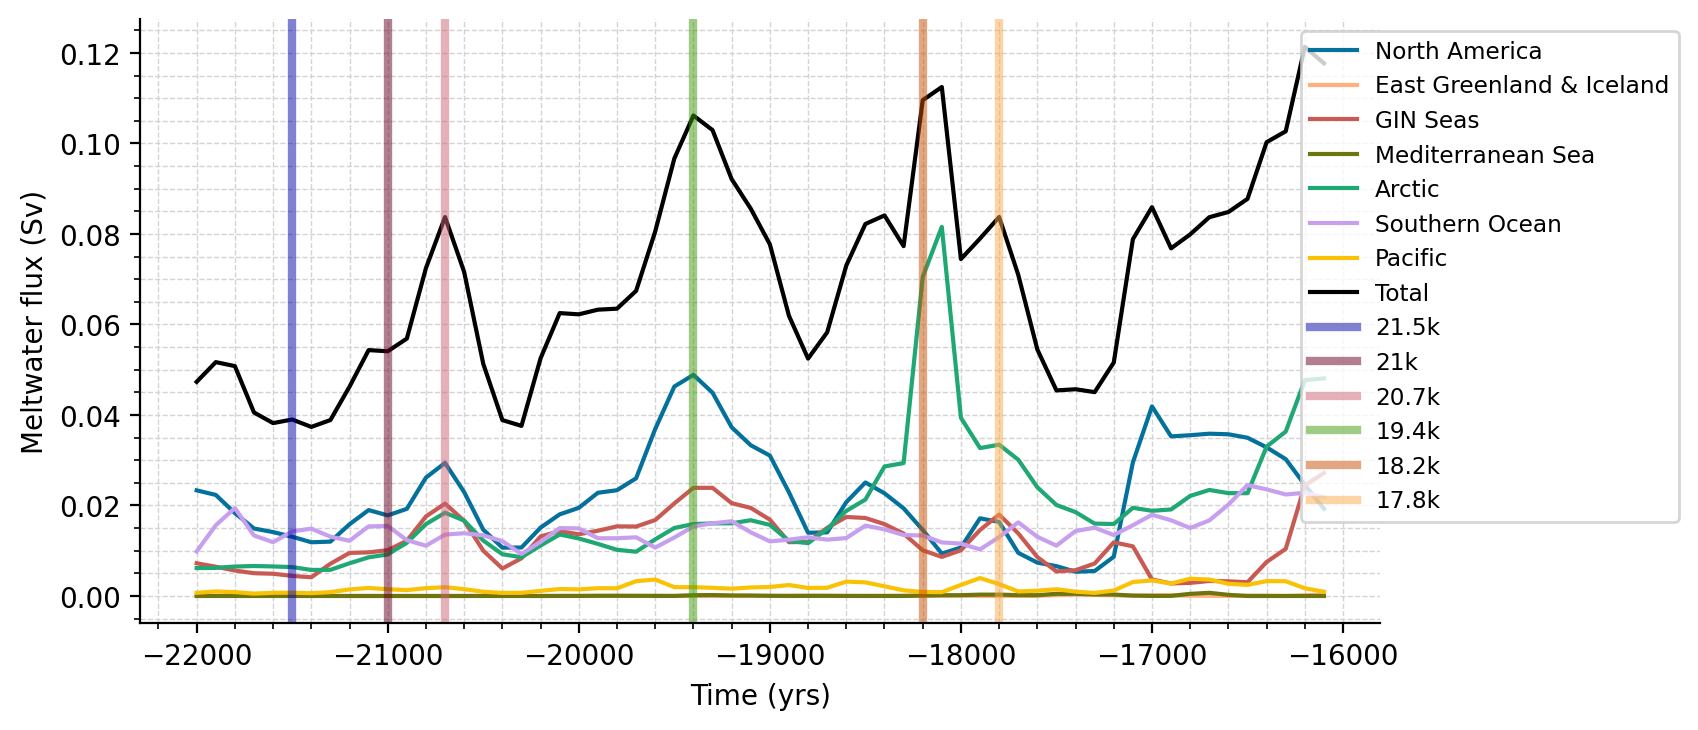

In [33]:
start_index, end_index = 40, 100

figMap, axMap = plt.subplots(nrows=1, ncols=1, figsize=(8,4), dpi=200)

axMap.plot(t[start_index:end_index], util.running_mean(flux_na[start_index:end_index],2), label="North America", color="xkcd:ocean blue", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_egi[start_index:end_index],2), label="East Greenland & Iceland", color="xkcd:peach", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_gin[start_index:end_index],2), label="GIN Seas", color="xkcd:dark salmon", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_med[start_index:end_index],2), label="Mediterranean Sea", color="xkcd:olive", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_arc[start_index:end_index],2), label="Arctic", color="xkcd:jade", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_ss[start_index:end_index],2), label="Southern Ocean", color="xkcd:lavender", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_pac[start_index:end_index],2), label="Pacific", color="xkcd:goldenrod", linestyle="-")
axMap.plot(t[start_index:end_index], util.running_mean(flux_tot[start_index:end_index],2), label="Total", color="black", linestyle="-")
axMap.axvline(x=-21500, color="xkcd:royal blue", label="21.5k", linewidth=3, alpha=0.5)
axMap.axvline(x=-21000, color="xkcd:maroon", label="21k", linewidth=3, alpha=0.5)
axMap.axvline(x=-20700, color="xkcd:rose", label="20.7k", linewidth=3, alpha=0.5)
axMap.axvline(x=-19400, color="xkcd:grass green", label="19.4k", linewidth=3, alpha=0.5)
axMap.axvline(x=-18200, color="xkcd:dark orange", label="18.2k", linewidth=3, alpha=0.5)
axMap.axvline(x=-17800, color="xkcd:light orange", label="17.8k", linewidth=3, alpha=0.5)

axMap.legend(loc="upper right", fontsize='small', bbox_to_anchor=(1.25, 1))
axMap.spines['right'].set_visible(False)
axMap.spines['top'].set_visible(False)
axMap.set_xlabel("Time (yrs)")
axMap.set_ylabel("Meltwater flux (Sv)")
axMap.minorticks_on()
axMap.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

*rq*: We also plot the flux over the entire last deglaciation

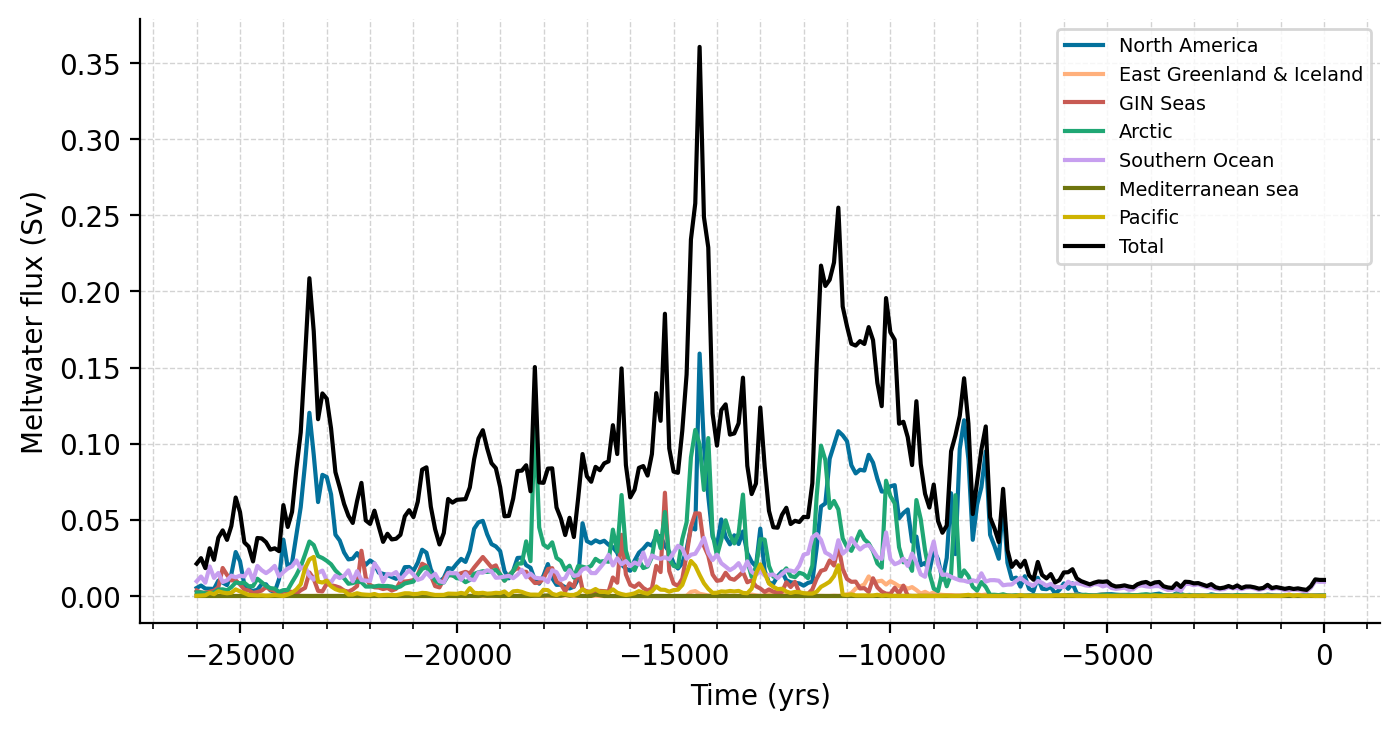

In [34]:
figMap, axMap = plt.subplots(nrows=1, ncols=1, figsize=(8,4), dpi=200)

axMap.plot(t, flux_na, label="North America", color="xkcd:ocean blue", linestyle="-")
axMap.plot(t, flux_egi, label="East Greenland & Iceland", color="xkcd:peach", linestyle="-")
axMap.plot(t, flux_gin, label="GIN Seas", color="xkcd:dark salmon", linestyle="-")
axMap.plot(t, flux_arc, label="Arctic", color="xkcd:jade", linestyle="-")
axMap.plot(t, flux_ss, label="Southern Ocean", color="xkcd:lavender", linestyle="-")
axMap.plot(t, flux_med, label="Mediterranean sea", color="xkcd:olive", linestyle="-")
axMap.plot(t, flux_pac, label="Pacific", color="xkcd:mustard", linestyle="-")
axMap.plot(t, flux_tot, label="Total", color="black", linestyle="-")


axMap.legend(loc="upper right", fontsize='x-small')
axMap.spines['right'].set_visible(False)
axMap.spines['top'].set_visible(False)
axMap.set_xlabel("Time (yrs)")
axMap.set_ylabel("Meltwater flux (Sv)")
axMap.xaxis.set_minor_locator(AutoMinorLocator())
axMap.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)

## Results

### Figure X - Control simulation

In [83]:
start_ctrl, end_ctrl = 4900, 4999
zone_na = zones.Box(lat_min=0)

ts = hcm3.SATATS("xoupa", start_ctrl, end_ctrl, chunks=100)
sat_ctrl = ts.sat(mode_t="mean", zone=zone_na)
lon_at, lat_at = sat_ctrl.lon_p, sat_ctrl.lat_p

ts = hcm3.MLDATS("xoupa", start_ctrl, end_ctrl, chunks=100)
mld_ctrl = ts.mld(mode_t="mean", zone=zone_na)
mld_values = mld_ctrl.values()
mld_values[-1] = mld_values[-2]
ts = hcm3.SSTATS("xoupa", start_ctrl, end_ctrl, chunks=100)
sst_ctrl = ts.sst(mode_t="mean", zone=zone_na)
sst_values = sst_ctrl.values()
sst_values[-1] = sst_values[-2]
lon_ocn, lat_ocn = mld_ctrl.lon_p, mld_ctrl.lat_p

ts = hcm3.WICEATS("xoupa", start_ctrl, end_ctrl, chunks=100)
wice_ctrl = ts.ice_conc(mode_t="mean")
ts = hcm3.SICEATS("xoupa", start_ctrl, end_ctrl, chunks=100)
sice_ctrl = ts.ice_conc(mode_t="mean")
lon_ice, lat_ice = wice_ctrl.lon_p, wice_ctrl.lat_p

ts = hcm3.MERIDATS("xoupa", start_ctrl, end_ctrl, chunks=100)
amoc_ctrl = ts.atlantic(zone=zones.Box(lat_min=-10), mode_t="mean")
lat_moc, z_moc = amoc_ctrl.lat, amoc_ctrl.z_p

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MLDATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing MLD.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing t: mean
__

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.WICEATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing winter (March) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Data compa

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(-0.3, 0.95, 'd')

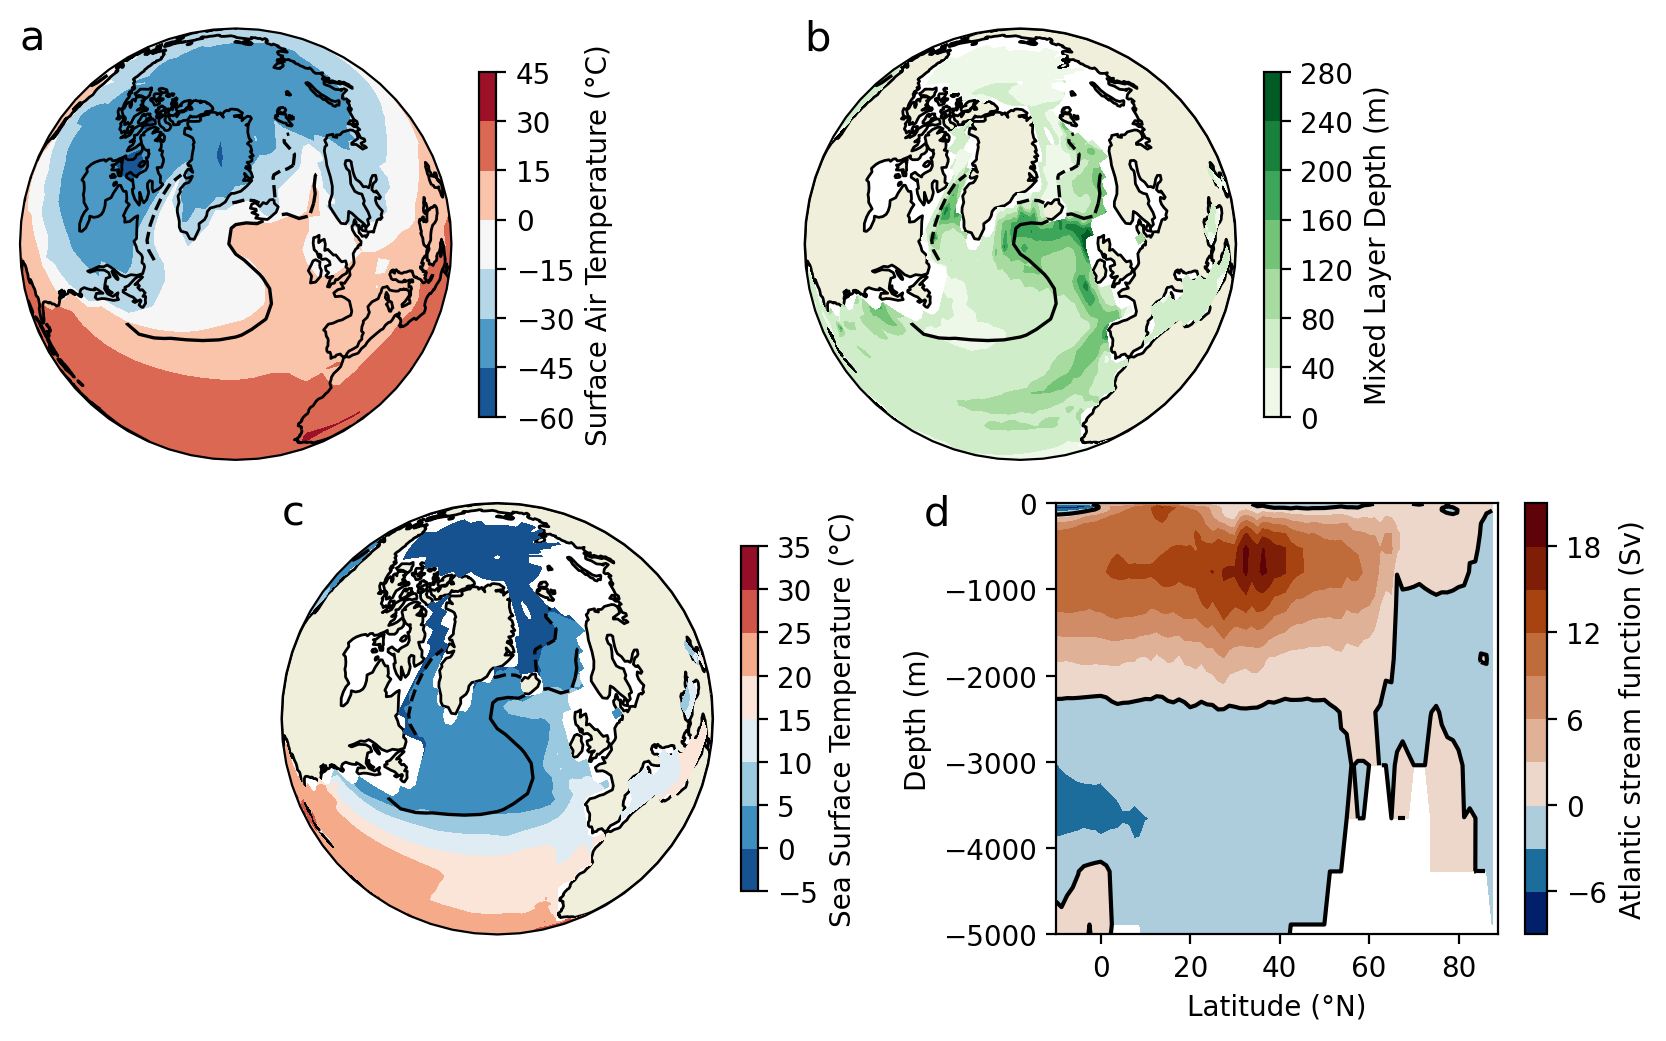

In [85]:
figMap = plt.figure(figsize=(12,6), dpi=200)
projection_map = ccrs.NearsidePerspective(central_longitude=-30, central_latitude=60, satellite_height=7000000)

gs = gridspec.GridSpec(nrows=2, ncols=7, wspace=-0.1, hspace=0.1)
axSAT = figMap.add_subplot(gs[0,0:2], projection = projection_map)
axMLD = figMap.add_subplot(gs[0,3:5], projection = projection_map)
axSST = figMap.add_subplot(gs[1,1:3], projection = projection_map)
axAMOC = figMap.add_subplot(gs[1,4:6])

# SAT

cmSAT = axSAT.contourf(lon_at, lat_at, sat_ctrl.values(), transform=ccrs.PlateCarree(), cmap="RdBu_r")
axSAT.contour(lon_ice, lat_ice, wice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='-')
axSAT.contour(lon_ice, lat_ice, sice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='--')
axSAT.set_global()
axSAT.coastlines()
figMap.colorbar(mappable=cmSAT, ax=axSAT, label="Surface Air Temperature (°C)", shrink=0.8)

# SST

cmSST = axSST.contourf(lon_ocn, lat_ocn, sst_values, transform=ccrs.PlateCarree(), cmap="RdBu_r")
axSST.contour(lon_ice, lat_ice, wice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='-')
axSST.contour(lon_ice, lat_ice, sice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='--')
axSST.set_global()
axSST.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cmSST, ax=axSST, label="Sea Surface Temperature (°C)", shrink=0.8)

# MLD

cmMLD = axMLD.contourf(lon_ocn, lat_ocn, mld_values, transform=ccrs.PlateCarree(), cmap="Greens")
axMLD.contour(lon_ice, lat_ice, wice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='-')
axMLD.contour(lon_ice, lat_ice, sice_ctrl.values(), transform=ccrs.PlateCarree(), levels=[0.5], colors='black',
              linewidths=1.2, linestyles='--')
axMLD.set_global()
axMLD.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cmMLD, ax=axMLD, label="Mixed Layer Depth (m)", shrink=0.8)

# AMOC
norm = matplotlib.colors.TwoSlopeNorm(vmin=-8, vcenter=0, vmax=20)
cmAMOC = axAMOC.contourf(lat_moc, z_moc, amoc_ctrl.values(), cmap=SCM6.vik, norm=norm, levels=8)
axAMOC.contour(lat_moc, z_moc, amoc_ctrl.values(), levels=[0], colors='black')
axAMOC.set_xlabel("Latitude (°N)")
axAMOC.set_ylabel("Depth (m)")
axAMOC.set_ylim([-5000,0])
figMap.colorbar(mappable=cmAMOC, ax=axAMOC, label="Atlantic stream function (Sv)")

axSAT.annotate('a', xy=(0, 0.95), xycoords='axes fraction', size=15)
axMLD.annotate('b', xy=(0, 0.95), xycoords='axes fraction', size=15)
axSST.annotate('c', xy=(0, 0.95), xycoords='axes fraction', size=15)
axAMOC.annotate('d', xy=(-0.3, 0.95), xycoords='axes fraction', size=15)

### Text - Global temperature changes

In [86]:
start_ctrl, end_ctrl = 4900, 4999

ts = hcm3.SATATS("xoupa", start_ctrl, end_ctrl)
sat_mean = ts.sat(mode_t="mean", mode_lon="weighted_mean", mode_lat="weighted_mean").values()
ts = hcm3.SSTATS("xoupa", start_ctrl, end_ctrl)
sst_mean = ts.sst(mode_t="mean", mode_lon="weighted_mean", mode_lat="weighted_mean").values()

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: weighted_mean
____ Processing latitude: weighted_mean
____ Processing t: mean
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 4900 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates imported in the GeoDataArray instance.
____ Processing longitude: weighted_mean
____ Processing latitude: weighted_mean
____ Processing t: mean


In [87]:
da = xr.open_dataset('/nfs/see-fs-01_users/eeymr/database/temea/climate/temeaa.pdclann.nc').temp_mm_srf
lat_weights = np.cos(np.deg2rad(da.latitude))
weights = da.weighted(lat_weights)
da = weights.mean("latitude")
sat_pi = da.isel(t=0).isel(surface=0).mean(dim="longitude").values - 273.15

da = xr.open_dataset('/nfs/see-fs-01_users/eeymr/database/temea/climate/temeao.pfclann.nc').temp_mm_uo
lat_weights = np.cos(np.deg2rad(da.latitude))
weights = da.weighted(lat_weights)
da = weights.mean("latitude")
sst_pi = da.isel(t=0).isel(unspecified=0).mean(dim="longitude").values

In [93]:
print(f"Global surface air temperature change : {sat_mean - sat_pi:.2f} °C")

Global surface air temperature change : -6.62 °C


In [94]:
print(f"Global sea surface temperature change : {sst_mean - sst_pi:.2f} °C")

Global sea surface temperature change : -3.42 °C


### Figure X - AMOC response to meltwater input

In [ ]:
amoc, ngrip, epica, precip, itcz_index ={}, {}, {}, {}, {}

for expt in ['xoupa', 'tfgbi', 'tfgbj', 'xoupf', 'xouph']:
    amoc[expt]=hcm3.MERIDATS(expt, chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
    epica[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon = 123)
    precip[expt] = hcm3.PRECIPATS(expt, chunks=10).precip()
    itcz_index[expt] = np.nanmean(util.calculate_itcz_lon_index(precip[expt]), axis=1)

amoc['xoupl'] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
amoc['xoupd'] = hcm3.MERIDATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.MERIDATS('xoupd', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
ngrip['xoupl'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngrip['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
epica['xoupl'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon = 123)
epica['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon = 123)
precip['xoupl'] = hcm3.PRECIPATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.PRECIPATS('xoupl', chunks=10)).precip()
precip['xoupd'] = hcm3.PRECIPATS('tfgbr', end_year=4060, chunks=10).concat(hcm3.PRECIPATS('xoupd', chunks=10)).precip()
itcz_index['xoupl'] = np.nanmean(util.calculate_itcz_lon_index(precip['xoupl']), axis=1)
itcz_index['xoupd'] = np.nanmean(util.calculate_itcz_lon_index(precip['xoupd']), axis=1)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longi

/nfs/see-fs-01_users/eeymr/scripts/pylaeoclim_leeds/util_hadcm3.py:498: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbi between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

/nfs/see-fs-01_users/eeymr/scripts/pylaeoclim_leeds/util_hadcm3.py:498: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

/nfs/see-fs-01_users/eeymr/scripts/pylaeoclim_leeds/util_hadcm3.py:498: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
__

/nfs/see-fs-01_users/eeymr/scripts/pylaeoclim_leeds/util_hadcm3.py:498: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xouph between years 1000 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xouph between years 1000 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ 

/nfs/see-fs-01_users/eeymr/scripts/pylaeoclim_leeds/util_hadcm3.py:498: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbd between years 1001 and 4060.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupd between years 4061 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic

/nfs/see-fs-01_users/eeymr/scripts/pylaeoclim_leeds/util_hadcm3.py:498: RuntimeWarning: Mean of empty slice
  return precip.lat[np.nanargmax(np.nanmean(precip.values(), axis=2), axis=1)]


In [ ]:
ds_discharge = xr.open_dataset('/nfs/see-fs-01_users/eeymr/work/outputs/glac_mw/Archive/glac.-26_0_100.diff_s/temev.discharge.glac_mw.nc',decode_times=False)
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temev/inidata/temev.qrparm.omask.nc')
ds_waterfix = xr.open_dataset('/nfs/annie/eeymr/work/data/glac_mw/qrparm.waterfix.hadcm3.nc')

ts = plotting.create_discharge_ts(ds_discharge, ds_lsm, ds_waterfix, unit="kg/m2/s", running_mean=2)
t = ds_discharge.t.values

index, total, na, arc, gin = {}, {}, {}, {}, {}
for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    index[expt] = np.where(t==-float(snapshots[expt])*1000)
    total[expt] = ts['Total'][index[expt]][0]
    na[expt] = ts['North America'][index[expt]][0]
    arc[expt] = ts['Arctic'][index[expt]][0]
    gin[expt] = ts['GIN'][index[expt]][0]

In [ ]:
figMap = plt.figure(figsize=(6, 9), dpi=200)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 3], hspace=0.2)
axMw = figMap.add_subplot(gs[0],facecolor='None')
gsts = gridspec.GridSpecFromSubplotSpec(4, 1, hspace=-0.01, subplot_spec=gs[1])
axAMOC = figMap.add_subplot(gsts[0], facecolor='None')
axNGRIP = figMap.add_subplot(gsts[1], sharex=axAMOC,facecolor='None')
axEPICA = figMap.add_subplot(gsts[2], sharex=axAMOC,facecolor='None')
axITCZ = figMap.add_subplot(gsts[3], sharex=axAMOC,facecolor='None')

# MELTWATER

locations = ['Total', 'North America', 'Arctic', 'GIN Seas']
x = np.arange(len(locations))  # the label locations
width = 0.15  # the width of the bars

values = {}
for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    values[expt] = [total[expt], na[expt], arc[expt], gin[expt]]
    
axMw.bar(x - 5*width/2, values['xoupd'], width, label=labels['xoupd'], color="xkcd:royal blue")
axMw.bar(x - 3*width/2, values['xouph'], width, label=labels['xouph'], color="xkcd:maroon")
axMw.bar(x - width/2, values['tfgbi'], width, label=labels['tfgbi'], color="xkcd:rose")
axMw.bar(x + width/2, values['xoupl'], width, label=labels['xoupl'], color="xkcd:grass green")
axMw.bar(x + 3*width/2, values['xoupf'], width, label=labels['xoupf'], color="xkcd:dark orange")
axMw.bar(x + 5*width/2, values['tfgbj'], width, label=labels['tfgbj'], color="xkcd:light orange")

axMw.spines['right'].set_visible(False)
axMw.spines['bottom'].set_visible(False)
axMw.spines['top'].set_visible(False)
axMw.set_ylabel("Meltwater flux (Sv)")
axMw.set_xticks(x)
axMw.set_xticklabels(locations)
axMw.xaxis.set_ticks_position('top')
axMw.xaxis.set_label_position('top')
axMw.tick_params(axis='x', which='both',length=0)
axMw.legend(fontsize='small', bbox_to_anchor=(1.1, 1))
axMw.annotate('a', xy=(0.01,0.9), xycoords='axes fraction', size=15)

for expt in expts:
    
    start = 1000 if expt == 'xoupa' else 0
        
    axAMOC.plot(amoc[expt].processed_time(start_dates[expt])[start:], util.running_mean(amoc[expt].values()[start:], 30), color=colors[expt], linewidth=1, linestyle="-")
    axAMOC.plot(amoc[expt].processed_time(start_dates[expt])[start:], amoc[expt].values()[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.2)
    if expt in smooth_date.keys():
        axAMOC.scatter(smooth_date[expt],  20, color=colors[expt], marker='v', linewidth=0, alpha=0.5)

    val = ngrip[expt].values()
    val[0] = np.nan
    axNGRIP.plot(ngrip[expt].processed_time(start_dates[expt])[start:], util.running_mean(val,30)[start:], color=colors[expt], linewidth=1, linestyle="-")
    axNGRIP.plot(ngrip[expt].processed_time(start_dates[expt])[start:], val[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.2)

    val = epica[expt].values()
    val[0] = np.nan
    axEPICA.plot(epica[expt].processed_time(start_dates[expt])[start:], util.running_mean(val,30)[start:], color=colors[expt], linewidth=1, linestyle="-")
    axEPICA.plot(epica[expt].processed_time(start_dates[expt])[start:], val[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.2)

    val = itcz_index[expt]
    val[0] = np.nan
    axITCZ.plot(precip[expt].processed_time(start_dates[expt])[start:], util.running_mean(val, 50)[start:], linewidth=1, color=colors[expt], linestyle="-", alpha=0.8)
    axITCZ.plot(precip[expt].processed_time(start_dates[expt])[start:], val[start:], color=colors[expt], linewidth=1, linestyle="-", alpha=0.2)

axAMOC.set_ylabel('Max AMOC at 26.5° N (Sv)')
axAMOC.spines['left'].set_visible(False)
axAMOC.spines['bottom'].set_visible(False)
axAMOC.yaxis.set_ticks_position('right')
axAMOC.yaxis.set_label_position('right')
axAMOC.xaxis.set_ticks_position('top')
axAMOC.set_xlabel("Simulation years")
axAMOC.xaxis.set_label_position('top')
axAMOC.xaxis.set_minor_locator(AutoMinorLocator())
axAMOC.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axAMOC.annotate('b', xy=(0.01,0.82), xycoords='axes fraction', size=15)

axNGRIP.spines['right'].set_visible(False)
axNGRIP.spines['top'].set_visible(False)
axNGRIP.spines['bottom'].set_visible(False)
axNGRIP.set_ylabel('NGRIP Temperature (°C)')
axNGRIP.set_ylim(-61, -35)
axNGRIP.tick_params(axis='x', colors='None', which='both')
axNGRIP.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIP.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIP.annotate('c', xy=(0.01,0.85), xycoords='axes fraction', size=15)

axEPICA.spines['left'].set_visible(False)
axEPICA.spines['top'].set_visible(False)
axEPICA.spines['bottom'].set_visible(False)
axEPICA.tick_params(axis='x', colors='None', which="both")
axEPICA.xaxis.set_minor_locator(AutoMinorLocator())
axEPICA.yaxis.set_ticks_position('right')
axEPICA.yaxis.set_label_position('right')
axEPICA.set_ylabel('EPICA Temperature (°C)')
axEPICA.set_ylim(-69, -61)
axEPICA.xaxis.set_minor_locator(AutoMinorLocator())
axEPICA.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)
axEPICA.annotate('d', xy=(0.01,0.75), xycoords='axes fraction', size=15)

axITCZ.spines['right'].set_visible(False)
axITCZ.spines['top'].set_visible(False)
axITCZ.set_xlabel("Simulation years")
axITCZ.xaxis.set_minor_locator(AutoMinorLocator())
axITCZ.yaxis.set_ticks_position('left')
axITCZ.yaxis.set_label_position('left')
axITCZ.set_ylabel('ITCZ index (°N)')
axITCZ.set_ylim(14, 20)
axITCZ.grid(which = "both", color='lightgrey', linestyle='--', linewidth=0.5)
axITCZ.annotate('e', xy=(0.01,0.85), xycoords='axes fraction', size=15)

### Figure X - Frequency analysis

In [11]:
ngrip = {}

for expt in ['tfgbi', 'xoupf', 'tfgbj', 'xouph']:
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngrip['tfgbr'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
ngrip['xoupd'] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ N

In [27]:
filt, psd, fq, harm, fc, ngripf, ngripf_u = {}, {}, {}, {}, {}, {}, {}

filt_u = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)

for expt in ['tfgbi', 'tfgbr', 'xoupf', 'tfgbj', 'xoupd', 'xouph']:
    psd[expt], fq[expt] = util.psd(ngrip[expt].values(), fs=1, scale_by_freq=True)
    harm[expt] = np.where(fq[expt]<=10**-1)
    fc[expt] = util.fundamental_fq(psd[expt], fq[expt])
    filt[expt] = util.ButterLowPass(order=1, fc=fc[expt], fs=1, mult=3)
    
    ngripf[expt] = filt[expt].process(ngrip[expt].values())    
    ngripf_u[expt] = filt_u.process(ngrip[expt].values())

<ipython-input-13-e89d6cb7433d>:52: RuntimeWarning: divide by zero encountered in true_divide
  axSpectrum.secondary_xaxis('top', functions=(lambda a : 1/a, lambda a : 1/a)).set_xlabel('Periodicity (yrs)')


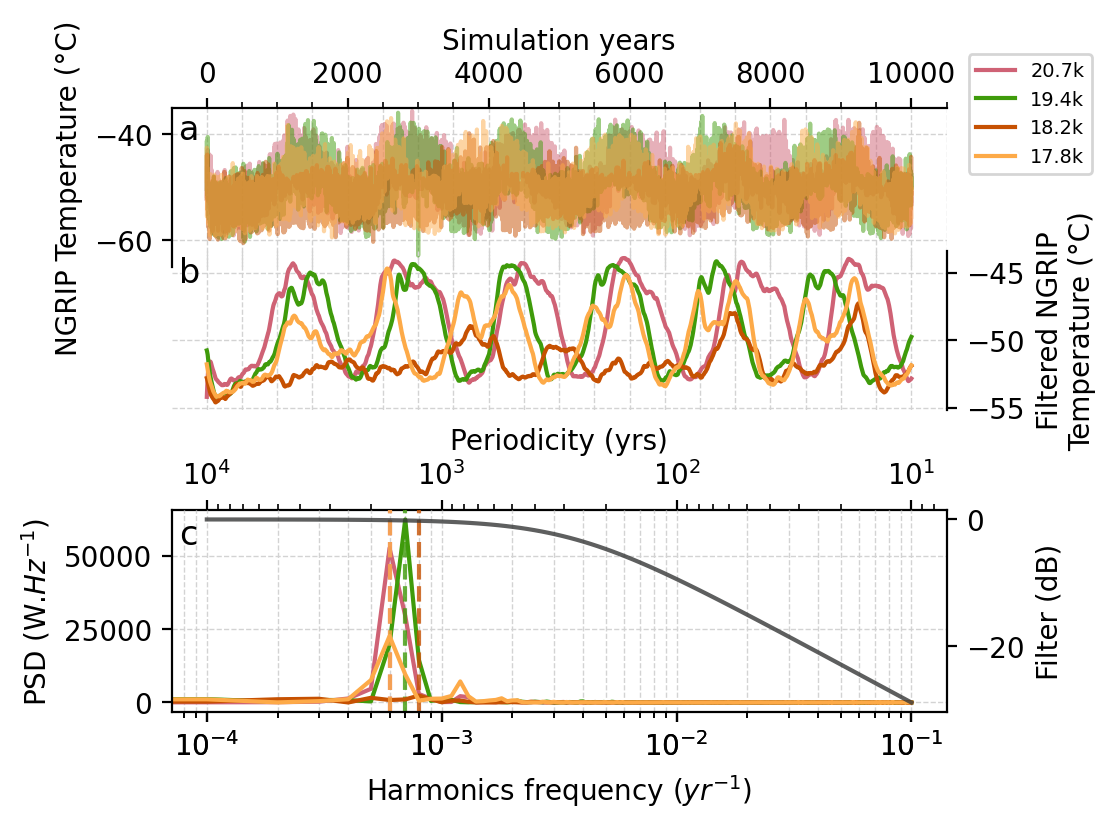

In [13]:
figMap = plt.figure(figsize=(5,4), dpi=200)

gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3, 2], hspace=0.4)
gsts = gridspec.GridSpecFromSubplotSpec(2, 1, hspace=-0.1, subplot_spec=gs[0])
axData = figMap.add_subplot(gsts[0],facecolor='None')
axFilt = figMap.add_subplot(gsts[1],facecolor='None', sharex=axData)
axSpectrum = figMap.add_subplot(gs[1],facecolor='None')
axFilter = axSpectrum.twinx()

for expt in ['tfgbi', 'tfgbr', 'xoupf', 'tfgbj']:
    axData.plot(ngrip[expt].processed_time(start_dates[expt]), ngrip[expt].values(), color=colors[expt], alpha=0.5, linestyle="-")
    axFilt.plot(ngrip[expt].processed_time(start_dates[expt]), ngripf_u[expt], color=colors[expt], label=labels[expt])
    axSpectrum.semilogx(fq[expt][harm[expt]], psd[expt][harm[expt]], color=colors[expt])
    axSpectrum.axvline(fc[expt], linestyle='--', color=colors[expt], alpha=0.8)

filter_temp = filt[expt].plot(min_power=-4, max_power=-1, n_fq=100)
axFilter.semilogx(filter_temp[0], 20 * np.log10(abs(filter_temp[1])), color="xkcd:dark grey", alpha=0.8)
    
axData.spines['right'].set_visible(False)
axData.spines['bottom'].set_visible(False)
axData.set_ylabel('NGRIP Temperature (°C)')
axData.set_ylim(-65, -35)
axData.xaxis.set_ticks_position('top')
axData.set_xlabel("Simulation years")
axData.xaxis.set_label_position('top')
axData.xaxis.set_minor_locator(AutoMinorLocator())
axData.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axData.annotate('a', xy=(0.01,0.8), xycoords='axes fraction', size=12)

axFilt.spines['left'].set_visible(False)
axFilt.spines['top'].set_visible(False)
axFilt.spines['bottom'].set_visible(False)
axFilt.yaxis.set_ticks_position('right')
axFilt.yaxis.set_label_position('right')
axFilt.set_ylabel("Filtered NGRIP\nTemperature (°C)")
axFilt.xaxis.set_minor_locator(AutoMinorLocator())
axFilt.tick_params(axis='x', colors='None', which='both')
axFilt.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axFilt.legend(fontsize='x-small', bbox_to_anchor=(1.2, 2.3))
axFilt.annotate('b', xy=(0.01,0.8), xycoords='axes fraction', size=12)

axSpectrum.spines['right'].set_visible(False)
axSpectrum.spines['top'].set_visible(False)
axSpectrum.yaxis.set_ticks_position('left')
axSpectrum.yaxis.set_label_position('left')
axSpectrum.set_ylabel(r"PSD (W.$Hz^{-1}$)")
axSpectrum.set_xlabel(r"Harmonics frequency ($yr^{-1}$)")
axSpectrum.xaxis.set_minor_locator(LogLocator(base=10,subs=[2,3,4,5,6,7,8,9]))
axSpectrum.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axSpectrum.annotate('c', xy=(0.01,0.83), xycoords='axes fraction', size=12)

axSpectrum.secondary_xaxis('top', functions=(lambda a : 1/a, lambda a : 1/a)).set_xlabel('Periodicity (yrs)')

axFilter.spines['left'].set_visible(False)
axFilter.spines['top'].set_visible(False)
axFilter.spines['bottom'].set_visible(False)
axFilter.yaxis.set_ticks_position('right')
axFilter.yaxis.set_label_position('right')
axFilter.set_ylabel("Filter (dB)")
axFilter.axes.xaxis.set_visible(True)

In [26]:
print(f" 20.7k - Dominant fq : {fc['tfgbi']:.3e}, period {1/fc['tfgbi']:.3e}")
print(f" 19.4k - Dominant fq : {fc['tfgbr']:.3e}, period {1/fc['tfgbr']:.3e}")
print(f" 18.2k - Dominant fq : {fc['xoupf']:.3e}, period {1/fc['xoupf']:.3e}")
print(f" 17.8k - Dominant fq : {fc['tfgbj']:.3e}, period {1/fc['tfgbj']:.3e}")

 20.7k - Dominant fq : 5.999e-04, period 1.667e+03
 19.4k - Dominant fq : 6.999e-04, period 1.429e+03
 18.2k - Dominant fq : 7.999e-04, period 1.250e+03
 17.8k - Dominant fq : 6.001e-04, period 1.666e+03


### Figure X - Zonal Means

In [2]:
lon_at_min, lon_at_max, lat_at_min, lat_at_max = 290, 370, -20, 80
zone_at = util.cycle_box(lon_at_min, lon_at_max, lat_at_min, lat_at_max)
box_at = zones.Box(lon_at_min, lon_at_max, lat_at_min, lat_at_max, z_min = -1000)
plane_at = zones.Box(lon_at_min, lon_at_max, lat_at_min, lat_at_max)

clim = {'xoupd':14, 'xouph':12, 'tfgbi':8, 'tfgbj':8, 'xoupl':8, 'xoupf':8}
wlim = {'xoupd':14.5, 'xouph':14.5, 'tfgbi':15, 'tfgbj':15, 'xoupl':16, 'xoupf':13.5}

In [5]:
amocv, amocts, amocc, amocw, amocv, idxes = {}, {}, {}, {}, {}, {}
amoc, sat, sst, mld, wice, sice = {}, {}, {}, {}, {}, {}
amoc_mode, sat_mode, sst_mode, mld_mode, wice_mode, sice_mode = {}, {}, {}, {}, {}, {}

amoc_ref = hcm3.MERIDATS('xoupa', chunks=10).atlantic(mode_z="max", mode_t='mean', zone=zones.Box(lat_min=-20, lat_max=80)).values()
sat_ref = hcm3.SATATS('xoupa', chunks=10).sat(mode_lon="mean", mode_t='mean', zone=plane_at).values()
sst_ref = hcm3.SSTATS('xoupa', chunks=10).sst(mode_lon="mean", mode_t='mean', zone=plane_at).values()
mld_ref = hcm3.MLDATS('xoupa', chunks=10).mld(mode_lon="mean", mode_t='mean', zone=plane_at).values()
wice_ref = hcm3.WICEATS('xoupa', chunks=10).ice_conc(mode_lon="mean", mode_t='mean', zone=plane_at).values()*100
sice_ref = hcm3.SICEATS('xoupa', chunks=10).ice_conc(mode_lon="mean", mode_t='mean', zone=plane_at).values()*100

for mode in ['Cold', 'Warm']:
    amoc_mode[mode], sat_mode[mode], sst_mode[mode], mld_mode[mode], wice_mode[mode], sice_mode[mode] = {}, {}, {}, {}, {}, {}
    idxes[mode] = {}
    
for expt in ['tfgbi', 'xoupl', 'tfgbj', 'xoupd', 'xouph', 'xoupf']:
    
    # Calculate AMOC Index Time series
    
    if expt == 'xoupl':
        amocts[expt] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(
            hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    elif expt == 'xoupd':
        amocts[expt] = hcm3.MERIDATS('tfgbd', end_year=4060, chunks=10).concat(
            hcm3.MERIDATS('xoupd', chunks=10)).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    else:
        amocts[expt] = hcm3.MERIDATS(expt, chunks=10).atlantic(mode_lat="value", value_lat=26.5, mode_z="max")
    amocv[expt] = util.running_mean(amocts[expt].values(), 30)
    amocc[expt] = np.where(amocv[expt]<=clim[expt], amocv[expt], np.nan)
    amocw[expt] = np.where(amocv[expt]>=wlim[expt], amocv[expt], np.nan)
    idxes['Cold'][expt] = np.where(amocv[expt]<=clim[expt])
    idxes['Warm'][expt] = np.where(amocv[expt]>=wlim[expt])
    
    
    # Calculate AMOC zonal mean
    
    if expt == 'xoupl':
        amoc[expt] = hcm3.MERIDATS('tfgbr', end_year=3999, chunks=10).concat(
            hcm3.MERIDATS('xoupl', chunks=10)).atlantic(mode_z="max", zone=zones.Box(lat_min=-20, lat_max=80))
    elif expt == 'xoupd':
        amoc[expt] = hcm3.MERIDATS('tfgbd', end_year=4060, chunks=10).concat(
            hcm3.MERIDATS('xoupd', chunks=10)).atlantic(mode_z="max", zone=zones.Box(lat_min=-20, lat_max=80))
    else:
        amoc[expt]=hcm3.MERIDATS(expt, chunks=10).atlantic(mode_z="max", zone=zones.Box(lat_min=-20, lat_max=80))    
    amoc_mode['Cold'][expt] = np.nanmean(amoc[expt].values()[idxes['Cold'][expt]], axis=0)
    amoc_mode['Warm'][expt] = np.nanmean(amoc[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate SAT zonal mean
    
    if expt == 'xoupl':
        sat[expt] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lon="mean", zone=plane_at)
    elif expt == 'xoupd':
        sat[expt] = hcm3.SATATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SATATS('xoupd', chunks=10)).sat(mode_lon="mean", zone=plane_at)
    else:
        sat[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lon="mean", zone=plane_at)
#     # Indexes of anual times series are one year shorter than amoc
#     cind[expt] = cind[expt][0][np.where(cind[expt][0]<len(sat[expt].values())-1)]
#     wind[expt] = wind[expt][0][np.where(wind[expt][0]<len(sat[expt].values())-1)]
    sat_mode['Cold'][expt] = np.nanmean(sat[expt].values()[idxes['Cold'][expt]], axis=0)
    sat_mode['Warm'][expt] = np.nanmean(sat[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate SST zonal mean

    if expt == 'xoupl':
        sst[expt] = hcm3.SSTATS('tfgbr', end_year=3999, chunks=10).concat(
            hcm3.SSTATS('xoupl', chunks=10)).sst(mode_lon="mean", zone=plane_at)
    elif expt == 'xoupd':
        sst[expt] = hcm3.SSTATS('tfgbd', end_year=4060, chunks=10).concat(
            hcm3.SSTATS('xoupd', chunks=10)).sst(mode_lon="mean", zone=plane_at)
    else:
        sst[expt] = hcm3.SSTATS(expt, chunks=10).sst(mode_lon="mean", zone=plane_at)
    sst_mode['Cold'][expt] = np.nanmean(sst[expt].values()[idxes['Cold'][expt]], axis=0)
    sst_mode['Warm'][expt] = np.nanmean(sst[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate MLD zonal mean
    
    if expt == 'xoupl':
        mld[expt] = hcm3.MLDATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.MLDATS('xoupl', chunks=10)).mld(mode_lon="mean", zone=plane_at)
    elif expt == 'xoupd':
        mld[expt] = hcm3.MLDATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.MLDATS('xoupd', chunks=10)).mld(mode_lon="mean", zone=plane_at)
    else:
        mld[expt] = hcm3.MLDATS(expt, chunks=10).mld(mode_lon="mean", zone=plane_at)
    mld_mode['Cold'][expt] = np.nanmean(mld[expt].values()[idxes['Cold'][expt]], axis=0)
    mld_mode['Warm'][expt] = np.nanmean(mld[expt].values()[idxes['Warm'][expt]], axis=0)

    # Calculate Winter sea ice zonal mean
    
    if expt == 'xoupl':
        wice[expt] = hcm3.WICEATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.WICEATS('xoupl', chunks=10)).ice_conc(mode_lon="mean", zone=plane_at)
    elif expt == 'xoupd':
        wice[expt] = hcm3.WICEATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.WICEATS('xoupd', chunks=10)).ice_conc(mode_lon="mean", zone=plane_at)
    else:
        wice[expt] = hcm3.WICEATS(expt, chunks=10).ice_conc(mode_lon="mean", zone=plane_at)
    wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
    wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100

    # Calculate Summer sea ice zonal mean
    
    if expt == 'xoupl':
        sice[expt] = hcm3.SICEATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SICEATS('xoupl', chunks=10)).ice_conc(mode_lon="mean", zone=plane_at)
    elif expt == 'xoupd':
        sice[expt] = hcm3.SICEATS('tfgbd', end_year=4060, chunks=10).concat(hcm3.SICEATS('xoupd', chunks=10)).ice_conc(mode_lon="mean", zone=plane_at)
    else:
        sice[expt] = hcm3.SICEATS(expt, chunks=10).ice_conc(mode_lon="mean", zone=plane_at)
    sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
    sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupa between years 1 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing z: max
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Processing t: mean
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SSTATS'> : xoupa between years 0 and 4999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SST.
____ Coordinates impo

<ipython-input-5-2beac5ac3b1d>:94: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:95: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbi between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-5-2beac5ac3b1d>:105: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:106: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlanti

<ipython-input-5-2beac5ac3b1d>:94: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:95: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbr between years 1001 and 3999.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xoupl between years 4001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-5-2beac5ac3b1d>:105: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:106: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbj between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates im

<ipython-input-5-2beac5ac3b1d>:94: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:95: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbj between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-5-2beac5ac3b1d>:105: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:106: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbd between years 1001 and 4060.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupd between years 4061 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : tfgbd between years 1001 and 4060.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupd between years 4061 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic)

<ipython-input-5-2beac5ac3b1d>:94: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:95: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : tfgbd between years 1001 and 4060.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xoupd between years 4061 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-5-2beac5ac3b1d>:105: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:106: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xouph between years 1000 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates impor

<ipython-input-5-2beac5ac3b1d>:94: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:95: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xouph between years 1001 and 5000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-5-2beac5ac3b1d>:105: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:106: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ New latitude value : 26.25
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.MERIDATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing meridional Overturning Stream Function (Atlantic).
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing z: max
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates im

<ipython-input-5-2beac5ac3b1d>:94: RuntimeWarning: Mean of empty slice
  wice_mode['Cold'][expt] = np.nanmean(wice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:95: RuntimeWarning: Mean of empty slice
  wice_mode['Warm'][expt] = np.nanmean(wice[expt].values()[idxes['Warm'][expt]], axis=0)*100


__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SICEATS'> : xoupf between years 1001 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing summer (September) sea ice fraction.
____ Coordinates imported in the GeoDataArray instance.
____ Data compacted to the zone.
____ Processing longitude: mean
____ Rebuilding the data_array


<ipython-input-5-2beac5ac3b1d>:105: RuntimeWarning: Mean of empty slice
  sice_mode['Cold'][expt] = np.nanmean(sice[expt].values()[idxes['Cold'][expt]], axis=0)*100
<ipython-input-5-2beac5ac3b1d>:106: RuntimeWarning: Mean of empty slice
  sice_mode['Warm'][expt] = np.nanmean(sice[expt].values()[idxes['Warm'][expt]], axis=0)*100


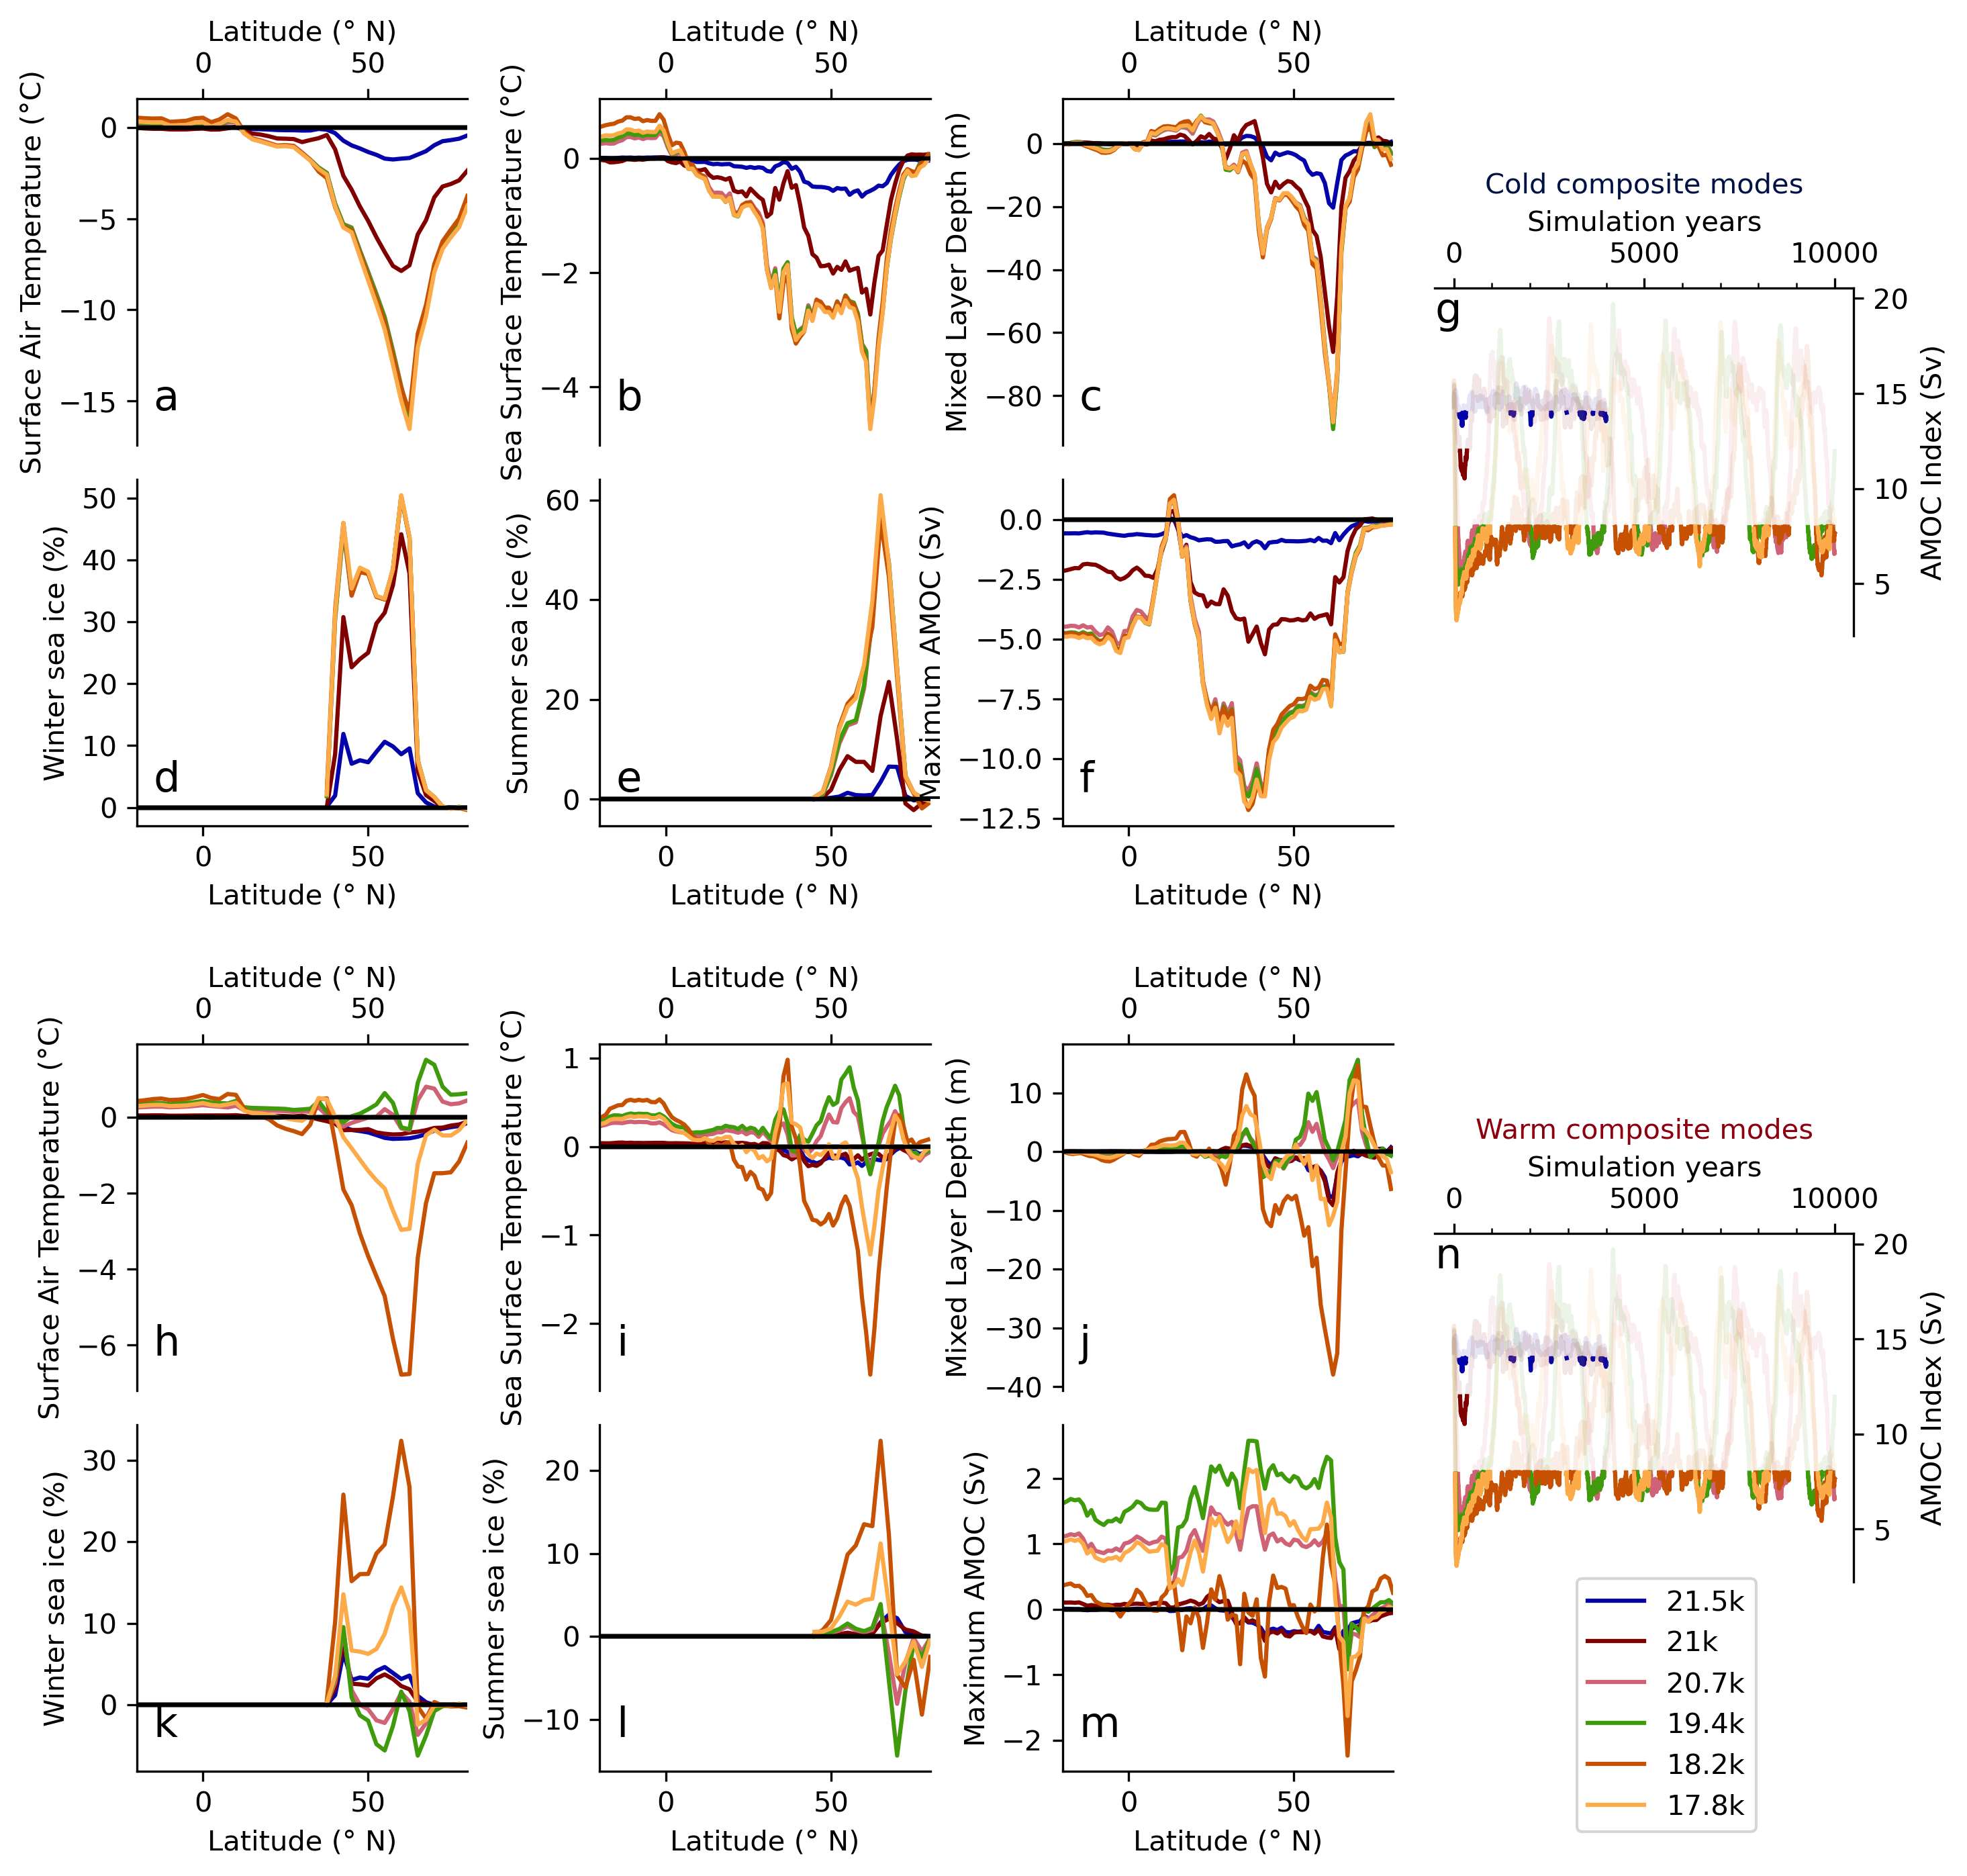

In [25]:
figMap = plt.figure(figsize=(11,11), dpi=300)

ax= {}
grid = figMap.add_gridspec(2, 1, hspace=0.3)
color_mode = {'Warm':'xkcd:crimson', 'Cold':'xkcd:navy blue'}

gridCold = grid[0].subgridspec(4, 2, width_ratios=[9,3], wspace=0.05)
ax['Cold'] = {}
gridColdPlots = gridCold[:,0].subgridspec(2, 3, wspace=0.4, hspace=0.1)
((ax['Cold']['SAT'], ax['Cold']['SST'], ax['Cold']['MLD']), 
 (ax['Cold']['WICE'], ax['Cold']['SICE'], ax['Cold']['AMOC'])) = gridColdPlots.subplots()
ax['Cold']['TS'] = figMap.add_subplot(gridCold[1:3,1])

gridWarm = grid[1].subgridspec(4, 2, width_ratios=[9,3], wspace=0.05)
ax['Warm'] = {}
gridWarmPlots = gridWarm[:,0].subgridspec(2, 3, wspace=0.4, hspace=0.1)
((ax['Warm']['SAT'], ax['Warm']['SST'], ax['Warm']['MLD']), 
 (ax['Warm']['WICE'], ax['Warm']['SICE'], ax['Warm']['AMOC'])) = gridWarmPlots.subplots()
ax['Warm']['TS'] = figMap.add_subplot(gridWarm[1:3,1])

letter = 'a'

for mode in ['Cold', 'Warm']:

    for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
        ax[mode]['SAT'].plot(sat[expt].lat, sat_mode[mode][expt] - sat_ref, color=colors[expt])
        ax[mode]['SST'].plot(sst[expt].lat, sst_mode[mode][expt] - sst_ref, color=colors[expt])
        ax[mode]['MLD'].plot(mld[expt].lat, mld_mode[mode][expt] - mld_ref, color=colors[expt])
        ax[mode]['WICE'].plot(wice[expt].lat, wice_mode[mode][expt] - wice_ref, color=colors[expt])
        ax[mode]['SICE'].plot(sice[expt].lat, sice_mode[mode][expt] - sice_ref, color=colors[expt])
        ax[mode]['AMOC'].plot(amoc[expt].lat, amoc_mode[mode][expt] - amoc_ref, color=colors[expt])

        for variable in ['SAT', 'SST', 'MLD', 'WICE', 'SICE', 'AMOC']:
            ax[mode][variable].axhline(y=0, color='k')
            ax[mode][variable].spines['right'].set_visible(False)
            ax[mode][variable].set_xlabel("Latitude (° N)")
            ax[mode][variable].set_xlim([-20,80])
            
        for variable in ['SAT', 'SST', 'MLD']:
            ax[mode][variable].spines['bottom'].set_visible(False)
            ax[mode][variable].xaxis.set_ticks_position('top')
            ax[mode][variable].xaxis.set_label_position('top')
            
        for variable in ['WICE', 'SICE', 'AMOC']:
            ax[mode][variable].spines['top'].set_visible(False)
            ax[mode][variable].xaxis.set_ticks_position('bottom')
            ax[mode][variable].xaxis.set_label_position('bottom')
            
            
    ax[mode]['SAT'].set_ylabel("Surface Air Temperature (°C)", fontsize='medium')
    ax[mode]['SST'].set_ylabel("Sea Surface Temperature (°C)", fontsize='medium')
    ax[mode]['SST'].set_ylabel("Sea Surface Temperature (°C)", fontsize='medium')
    ax[mode]['MLD'].set_ylabel("Mixed Layer Depth (m)")
    ax[mode]['WICE'].set_ylabel("Winter sea ice (%)")
    ax[mode]['SICE'].set_ylabel("Summer sea ice (%)")
    ax[mode]['AMOC'].set_ylabel("Maximum AMOC (Sv)")

    for variable in ['SAT', 'SST', 'MLD', 'WICE', 'SICE', 'AMOC']:
        ax[mode][variable].annotate(letter, xy=(0.05,0.1), xycoords='axes fraction', size=15)
        letter = chr(ord(letter)+1)

    
    for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
        ax[mode]['TS'].plot(amocts[expt].processed_time(start_dates[expt]), 
                            amocv[expt], color=colors[expt], linestyle="-", alpha=0.1)
        ax[mode]['TS'].plot(amocts[expt].processed_time(start_dates[expt]), 
                            amocc[expt], color=colors[expt], linestyle="-", label=labels[expt])
    ax[mode]['TS'].spines['left'].set_visible(False)
    ax[mode]['TS'].spines['bottom'].set_visible(False)
    ax[mode]['TS'].yaxis.set_ticks_position('right')
    ax[mode]['TS'].yaxis.set_label_position('right')
    ax[mode]['TS'].set_ylabel('AMOC Index (Sv)')
    ax[mode]['TS'].xaxis.set_ticks_position('top')
    ax[mode]['TS'].set_xlabel("Simulation years")
    ax[mode]['TS'].xaxis.set_label_position('top')
    ax[mode]['TS'].xaxis.set_minor_locator(AutoMinorLocator())
    
    ax[mode]['TS'].set_title(f"{mode} composite modes", fontsize='medium', color=color_mode[mode])
    
    ax[mode]['TS'].annotate(letter, xy=(0,0.9), xycoords='axes fraction', size=15)
    letter = chr(ord(letter)+1)
    
ax['Warm']['TS'].legend(fontsize='medium', bbox_to_anchor=(0.8, 0.05))


Text(0.05, 0.9, 'f')

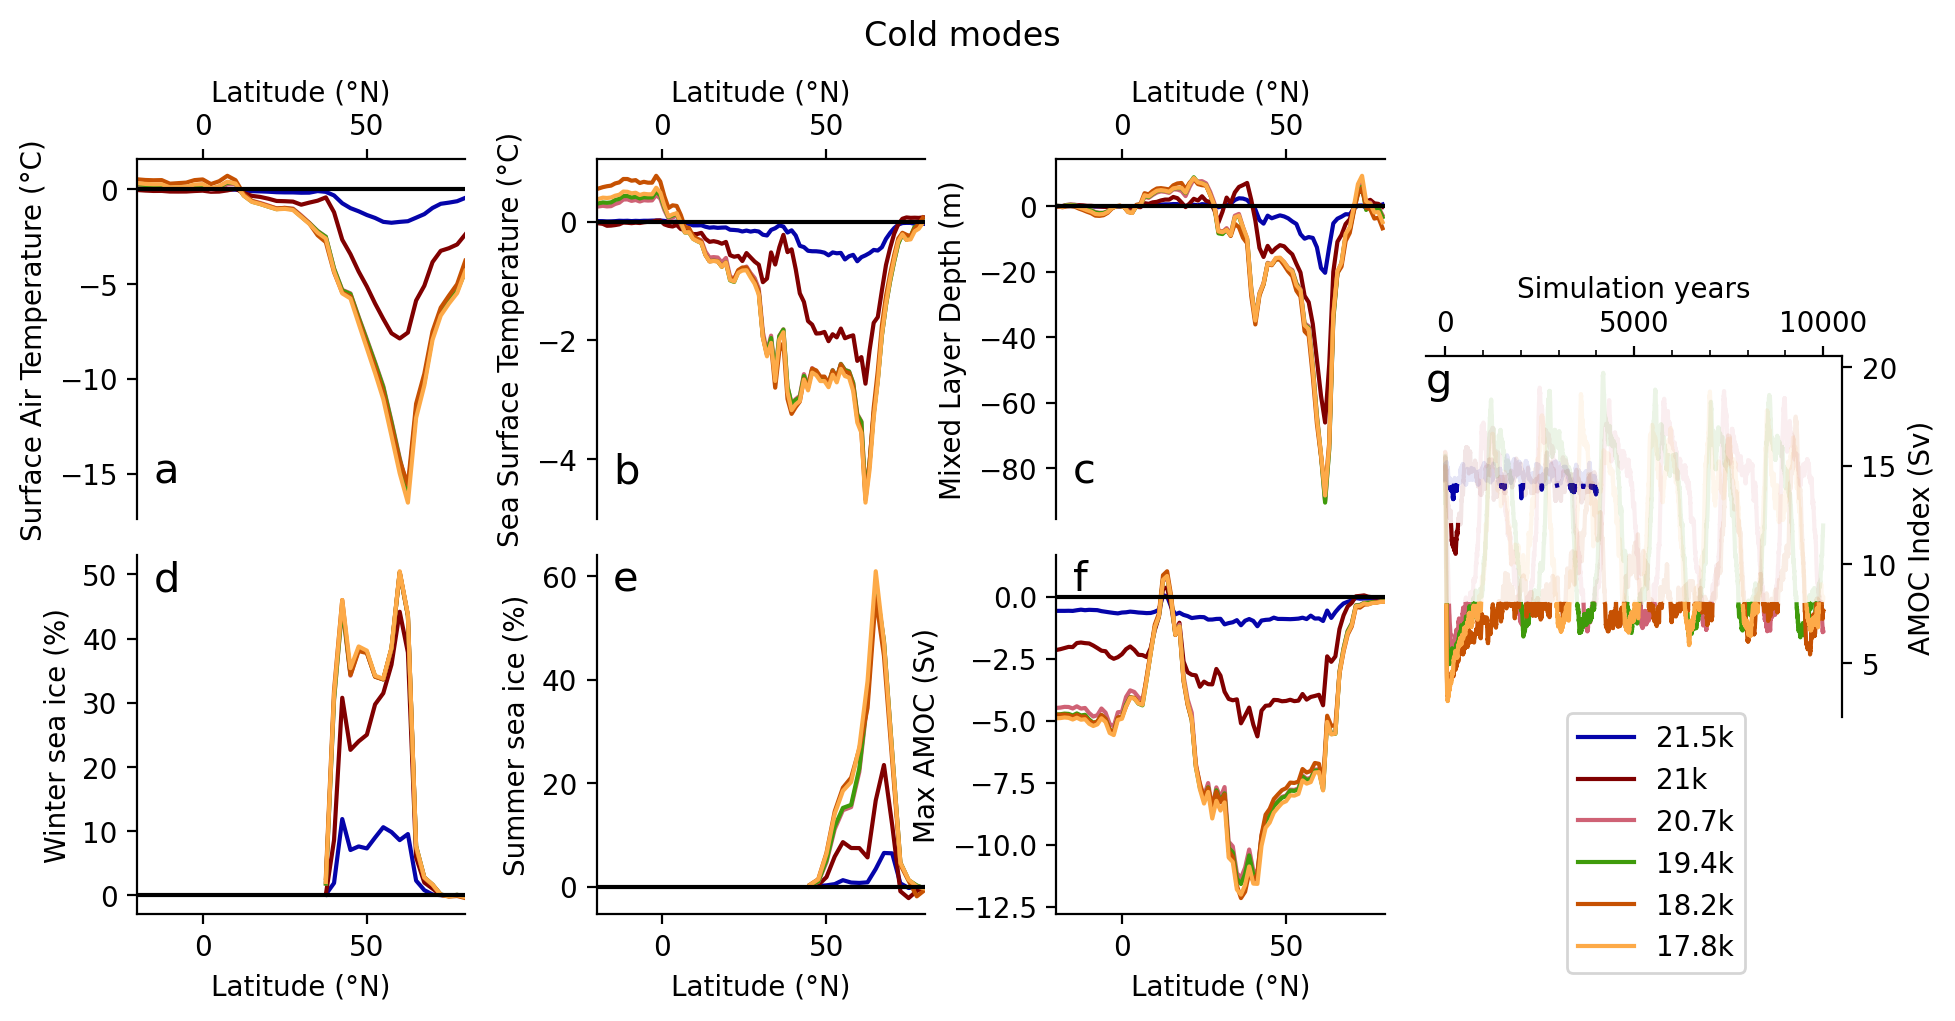

In [31]:
figMap = plt.figure(figsize=(11,5), dpi=200)

grid = figMap.add_gridspec(4, 2, width_ratios=[9,3], wspace=0.05)
gridPlots = grid[:,0].subgridspec(2, 3, wspace=0.4, hspace=0.1)
((axSAT, axSST, axMLD), (axWICE, axSICE, axAMOC)) = gridPlots.subplots()
axTS = figMap.add_subplot(grid[1:3,1])

figMap.suptitle("Cold modes", ha='center', x=0.5, y=1.02)

for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    axTS.plot(amocts[expt].processed_time(start_dates[expt]), amocv[expt], color=colors[expt], linestyle="-", alpha=0.1)
    axTS.plot(amocts[expt].processed_time(start_dates[expt]), amocc[expt], color=colors[expt], linestyle="-", label=labels[expt])
axTS.spines['left'].set_visible(False)
axTS.spines['bottom'].set_visible(False)
axTS.yaxis.set_ticks_position('right')
axTS.yaxis.set_label_position('right')
axTS.set_ylabel('AMOC Index (Sv)')
axTS.xaxis.set_ticks_position('top')
axTS.set_xlabel("Simulation years")
axTS.xaxis.set_label_position('top')
axTS.xaxis.set_minor_locator(AutoMinorLocator())
axTS.legend(fontsize='medium', bbox_to_anchor=(0.8, 0.05))
axTS.annotate('g', xy=(0,0.9), xycoords='axes fraction', size=15)


for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    axSAT.plot(sat[expt].lat, sat_st[expt] - sat_ref, color=colors[expt])
    
    axSST.plot(sst[expt].lat, sst_st[expt] - sst_ref, color=colors[expt])

    axMLD.plot(mld[expt].lat, mld_st[expt] - mld_ref, color=colors[expt])

    axWICE.plot(wice[expt].lat, wice_st[expt] - wice_ref, color=colors[expt])

    axSICE.plot(sice[expt].lat, sice_st[expt] - sice_ref, color=colors[expt])

    axAMOC.plot(amoc[expt].lat, amoc_st[expt] - amoc_ref, color=colors[expt])
    
axSAT.axhline(y=0, color='k')
axSAT.spines['right'].set_visible(False)
axSAT.spines['bottom'].set_visible(False)
axSAT.set_xlabel("Latitude (°N)")
axSAT.set_ylabel("Surface Air Temperature (°C)", fontsize='medium')
axSAT.xaxis.set_ticks_position('top')
axSAT.xaxis.set_label_position('top')
axSAT.set_xlim([-20,80])
axSAT.annotate('a', xy=(0.05,0.1), xycoords='axes fraction', size=15)

axSST.axhline(y=0, color='k')
axSST.spines['right'].set_visible(False)
axSST.spines['bottom'].set_visible(False)
axSST.set_xlabel("Latitude (°N)")
axSST.set_ylabel("Sea Surface Temperature (°C)", fontsize='medium')
axSST.xaxis.set_ticks_position('top')
axSST.xaxis.set_label_position('top')
axSST.set_xlim([-20,80])
axSST.annotate('b', xy=(0.05,0.1), xycoords='axes fraction', size=15)

axMLD.axhline(y=0, color='k')
axMLD.spines['right'].set_visible(False)
axMLD.spines['bottom'].set_visible(False)
axMLD.set_xlabel("Latitude (°N)")
axMLD.set_ylabel("Mixed Layer Depth (m)")
axMLD.xaxis.set_ticks_position('top')
axMLD.xaxis.set_label_position('top')
axMLD.set_xlim([-20,80])
axMLD.annotate('c', xy=(0.05,0.1), xycoords='axes fraction', size=15)

axWICE.axhline(y=0, color='k')
axWICE.spines['right'].set_visible(False)
axWICE.spines['top'].set_visible(False)
axWICE.set_xlabel("Latitude (°N)")
axWICE.set_ylabel("Winter sea ice (%)")
axWICE.set_xlim([-20,80])
axWICE.annotate('d', xy=(0.05,0.9), xycoords='axes fraction', size=15)

axSICE.axhline(y=0, color='k')
axSICE.spines['right'].set_visible(False)
axSICE.spines['top'].set_visible(False)
axSICE.set_xlabel("Latitude (°N)")
axSICE.set_ylabel("Summer sea ice (%)")
axSICE.set_xlim([-20,80])
axSICE.annotate('e', xy=(0.05,0.9), xycoords='axes fraction', size=15)

axAMOC.axhline(y=0, color='k')
axAMOC.spines['right'].set_visible(False)
axAMOC.spines['top'].set_visible(False)
axAMOC.set_xlabel("Latitude (°N)")
axAMOC.set_ylabel("Max AMOC (Sv)")
axAMOC.set_xlim([-20,80])
axAMOC.annotate('f', xy=(0.05,0.9), xycoords='axes fraction', size=15)

Text(0.05, 0.9, 'f')

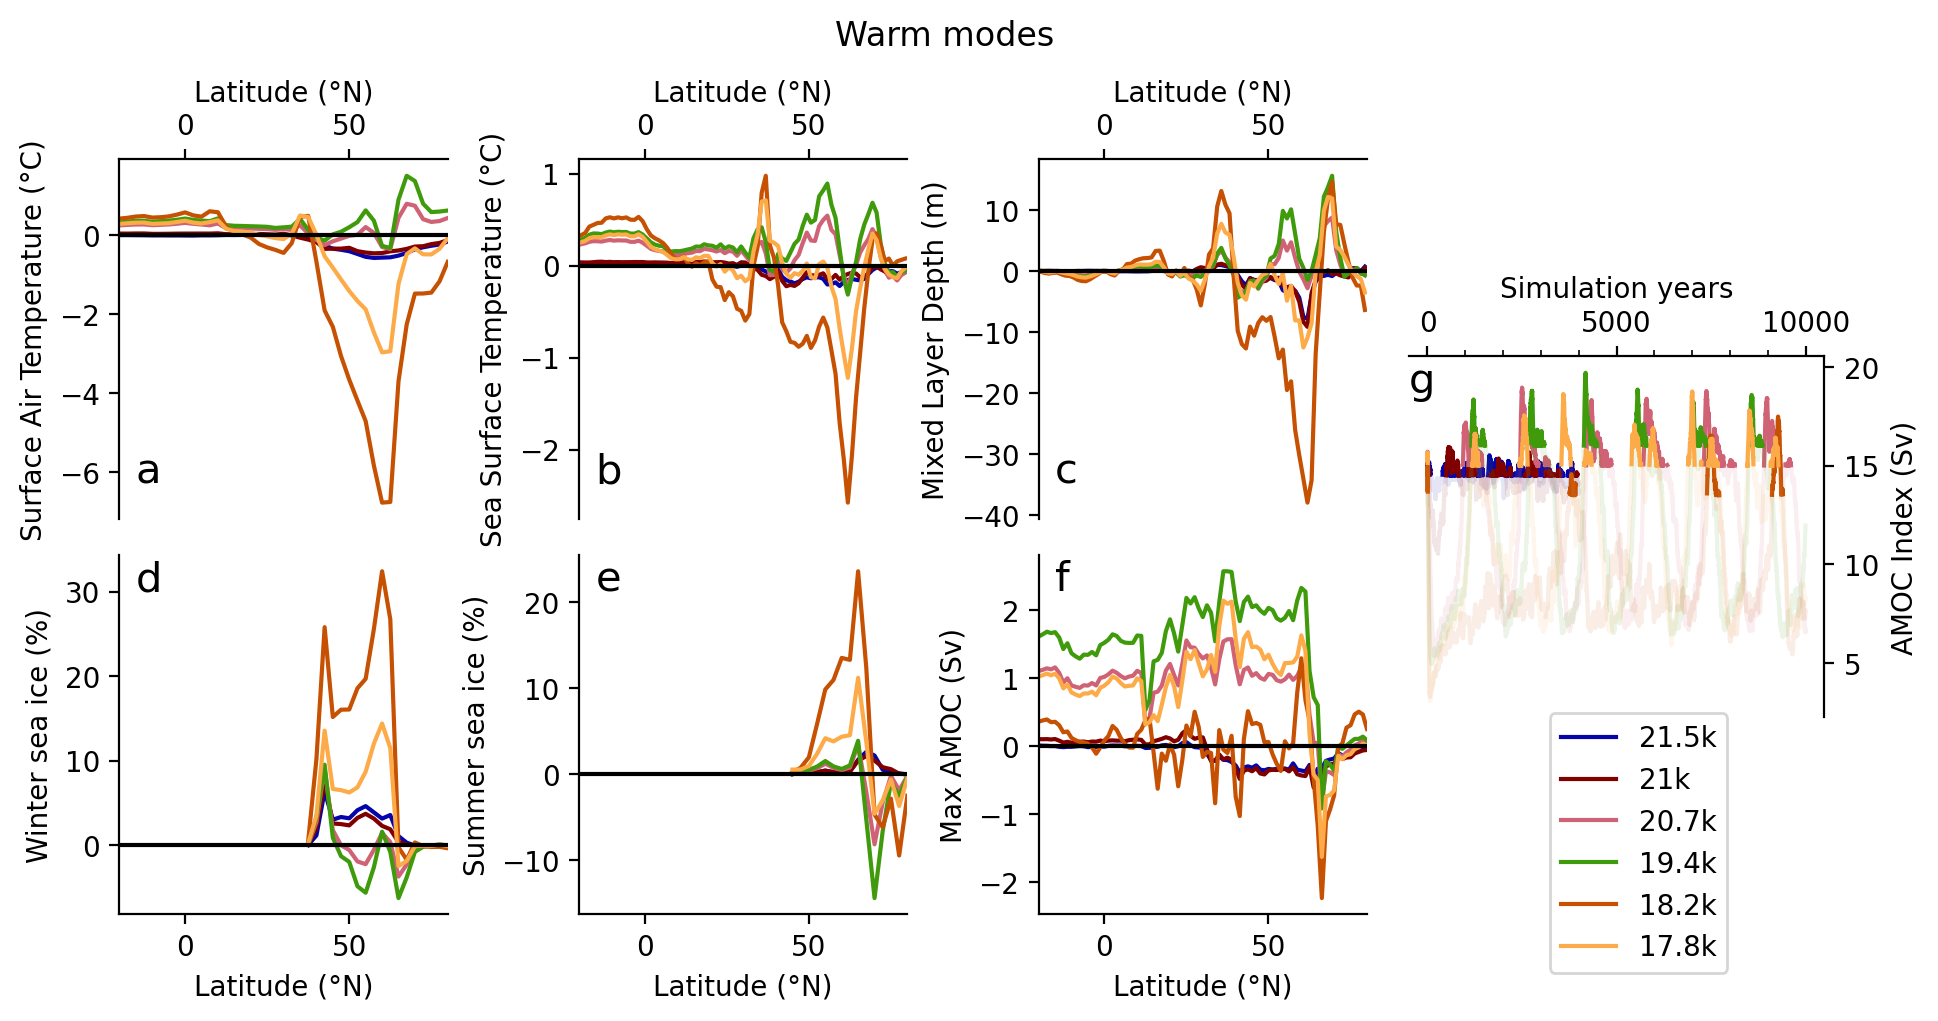

In [32]:
figMap = plt.figure(figsize=(11,5), dpi=200)

grid = figMap.add_gridspec(4, 2, width_ratios=[9,3], wspace=0.05)
gridPlots = grid[:,0].subgridspec(2, 3, wspace=0.4, hspace=0.1)
((axSAT, axSST, axMLD), (axWICE, axSICE, axAMOC)) = gridPlots.subplots()
axTS = figMap.add_subplot(grid[1:3,1])

figMap.suptitle("Warm modes", ha='center',va='top', x=0.5, y=1.02)

for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    axTS.plot(amocts[expt].processed_time(start_dates[expt]), amocv[expt], color=colors[expt], linestyle="-", alpha=0.1)
    axTS.plot(amoc[expt].processed_time(start_dates[expt]), amocw[expt], color=colors[expt], linestyle="-",  label=labels[expt])
axTS.spines['left'].set_visible(False)
axTS.spines['bottom'].set_visible(False)
axTS.yaxis.set_ticks_position('right')
axTS.yaxis.set_label_position('right')
axTS.set_ylabel('AMOC Index (Sv)')
axTS.xaxis.set_ticks_position('top')
axTS.set_xlabel("Simulation years")
axTS.xaxis.set_label_position('top')
axTS.xaxis.set_minor_locator(AutoMinorLocator())
axTS.legend(fontsize='medium', bbox_to_anchor=(0.8, 0.05))
axTS.annotate('g', xy=(0,0.9), xycoords='axes fraction', size=15)


for expt in ['xoupd', 'xouph', 'tfgbi', 'xoupl', 'xoupf', 'tfgbj']:
    axSAT.plot(sat[expt].lat, sat_it[expt] - sat_ref, color=colors[expt])
    
    axSST.plot(sst[expt].lat, sst_it[expt] - sst_ref, color=colors[expt])

    axMLD.plot(mld[expt].lat, mld_it[expt] - mld_ref, color=colors[expt])

    axWICE.plot(wice[expt].lat, wice_it[expt] - wice_ref, color=colors[expt])

    axSICE.plot(sice[expt].lat, sice_it[expt] - sice_ref, color=colors[expt])

    axAMOC.plot(amoc[expt].lat, amoc_it[expt] - amoc_ref, color=colors[expt])
    
axSAT.axhline(y=0, color='k')
axSAT.spines['right'].set_visible(False)
axSAT.spines['bottom'].set_visible(False)
axSAT.set_xlabel("Latitude (°N)")
axSAT.set_ylabel("Surface Air Temperature (°C)", fontsize='medium')
axSAT.xaxis.set_ticks_position('top')
axSAT.xaxis.set_label_position('top')
axSAT.set_xlim([-20,80])
axSAT.annotate('a', xy=(0.05,0.1), xycoords='axes fraction', size=15)

axSST.axhline(y=0, color='k')
axSST.spines['right'].set_visible(False)
axSST.spines['bottom'].set_visible(False)
axSST.set_xlabel("Latitude (°N)")
axSST.set_ylabel("Sea Surface Temperature (°C)", fontsize='medium')
axSST.xaxis.set_ticks_position('top')
axSST.xaxis.set_label_position('top')
axSST.set_xlim([-20,80])
axSST.annotate('b', xy=(0.05,0.1), xycoords='axes fraction', size=15)

axMLD.axhline(y=0, color='k')
axMLD.spines['right'].set_visible(False)
axMLD.spines['bottom'].set_visible(False)
axMLD.set_xlabel("Latitude (°N)")
axMLD.set_ylabel("Mixed Layer Depth (m)")
axMLD.xaxis.set_ticks_position('top')
axMLD.xaxis.set_label_position('top')
axMLD.set_xlim([-20,80])
axMLD.annotate('c', xy=(0.05,0.1), xycoords='axes fraction', size=15)

axWICE.axhline(y=0, color='k')
axWICE.spines['right'].set_visible(False)
axWICE.spines['top'].set_visible(False)
axWICE.set_xlabel("Latitude (°N)")
axWICE.set_ylabel("Winter sea ice (%)")
axWICE.set_xlim([-20,80])
axWICE.annotate('d', xy=(0.05,0.9), xycoords='axes fraction', size=15)

axSICE.axhline(y=0, color='k')
axSICE.spines['right'].set_visible(False)
axSICE.spines['top'].set_visible(False)
axSICE.set_xlabel("Latitude (°N)")
axSICE.set_ylabel("Summer sea ice (%)")
axSICE.set_xlim([-20,80])
axSICE.annotate('e', xy=(0.05,0.9), xycoords='axes fraction', size=15)

axAMOC.axhline(y=0, color='k')
axAMOC.spines['right'].set_visible(False)
axAMOC.spines['top'].set_visible(False)
axAMOC.set_xlabel("Latitude (°N)")
axAMOC.set_ylabel("Max AMOC (Sv)")
axAMOC.set_xlim([-20,80])
axAMOC.annotate('f', xy=(0.05,0.9), xycoords='axes fraction', size=15)

## Discussion

### Figure X - Model-DO comparision

In [2]:
# Import NGRIP and EPICA SAT values

ngrip, epica = {}, {}

for expt in ['tfgbi', 'xoupf', 'tfgbj']:
    ngrip[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon = 318)
    epica[expt] = hcm3.SATATS(expt, chunks=10).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon=123)
ngrip['tfgbr'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=75, mode_lon="value", value_lon=318)
epica['tfgbr'] = hcm3.SATATS('tfgbr', end_year=3999, chunks=10).concat(hcm3.SATATS('xoupl', chunks=10)).sat(mode_lat="value", value_lat=-75, mode_lon="value", value_lon=123)

__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ New latitude value : 75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : tfgbi between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 123.75
____ New latitude value : -75.0
____ Rebuilding the data_array
__ Importation of <class 'pylaeoclim_leeds.hadcm3_processing.SATATS'> : xoupf between years 1000 and 11000.
____ Import succeeded.
____ Coordinates imported in the HadCM3DS dataset.
__ Importing SAT.
____ Coordinates imported in the GeoDataArray instance.
____ New longitude value : 318.75
____ 

In [4]:
# Produce the filtered time series

filt, psd, fq, harm, fc, ngripf, epicaf = {}, {}, {}, {}, {}, {}, {}

for expt in ['tfgbi', 'tfgbr', 'xoupf', 'tfgbj']:
    psd[expt], fq[expt] = util.psd(ngrip[expt].values(), fs=1, scale_by_freq=True)
    harm[expt] = np.where(fq[expt]<=10**-1)
    fc[expt] = util.fundamental_fq(psd[expt], fq[expt])
    filt[expt] = util.ButterLowPass(order=1, fc=2*10**-3, fs=1, mult=2)
    
    ngripf[expt] = filt[expt].process(ngrip[expt].values())
    epicaf[expt] = filt[expt].process(epica[expt].values())

In [45]:
print(f"20.7k - Dominant frequency : {fc['tfgbi']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['tfgbi']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['tfgbi']) - np.min(ngripf['tfgbi']):.4g} °C")
print(f"19.4k - Dominant frequency : {fc['tfgbr']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['tfgbr']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['tfgbr']) - np.min(ngripf['tfgbr']):.4g} °C")
print(f"18.2k - Dominant frequency : {fc['xoupf']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['xoupf']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['xoupf']) - np.min(ngripf['xoupf']):.4g} °C")
print(f"17.8k - Dominant frequency : {fc['tfgbj']*1000:.4g} kyr\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE}, " + 
      f"periodicity : {1/fc['tfgbj']/1000:.4g} kyr, " + 
      f"amplitude: {np.max(ngripf['tfgbj']) - np.min(ngripf['tfgbj']):.4g} °C")

20.7k - Dominant frequency : 0.5999 kyr⁻¹, periodicity : 1.667 kyr, amplitude: 10.29 °C
19.4k - Dominant frequency : 0.6999 kyr⁻¹, periodicity : 1.429 kyr, amplitude: 10.02 °C
18.2k - Dominant frequency : 0.7999 kyr⁻¹, periodicity : 1.25 kyr, amplitude: 7.337 °C
17.8k - Dominant frequency : 0.6001 kyr⁻¹, periodicity : 1.666 kyr, amplitude: 9.49 °C


In [52]:
# The first hundred years are not taken into account

print(f" 20.7k - Warming rate : {np.max(np.diff(ngripf['tfgbi'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['tfgbi'])[100:])*100:.4g} °C/100yr")
print(f" 19.4k - Warming rate : {np.max(np.diff(ngripf['tfgbr'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['tfgbr'])[100:])*100:.4g} °C/100yr")
print(f" 18.2k - Warming rate : {np.max(np.diff(ngripf['xoupf'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['xoupf'])[100:])*100:.4g} °C/100yr")
print(f" 17.8k - Warming rate : {np.max(np.diff(ngripf['tfgbj'])[100:])*100:.4g} °C/100yr, " + 
      f"Cooling rate : {np.min(np.diff(ngripf['tfgbj'])[100:])*100:.4g} °C/100yr")

 20.7k - Warming rate : 4.935 °C/100yr, Cooling rate : -3.976 °C/100yr
 19.4k - Warming rate : 5.187 °C/100yr, Cooling rate : -3.715 °C/100yr
 18.2k - Warming rate : 2.841 °C/100yr, Cooling rate : -3.573 °C/100yr
 17.8k - Warming rate : 4.166 °C/100yr, Cooling rate : -5.281 °C/100yr


In [53]:
# Import proxy records between 44,000 and 40,000 ka BP

names_NGRIP = ['age', 'O18']
proxy_ngrip = pd.read_excel('/nfs/see-fs-01_users/eeymr/work/data/proxies_do/41586_2004_BFnature02805_MOESM1_ESM.xlsx', sheet_name='Data', names=names_NGRIP, na_values=['NAN'])
proxy_ngrip = proxy_ngrip.where(proxy_ngrip.age>=40000*1000).where(proxy_ngrip.age<=44000*1000)

names_EDML = ['age', 'O18']
proxy_edml = pd.read_excel('/nfs/see-fs-01_users/eeymr/work/data/proxies_do/EDML_d18O.xlsx', sheet_name='Data_simple', names=names_EDML, na_values=['NAN'])
proxy_edml = proxy_edml.where(proxy_edml.age>=40000/1000).where(proxy_edml.age<=44000/1000)

Text(0.01, 0.15, 'd')

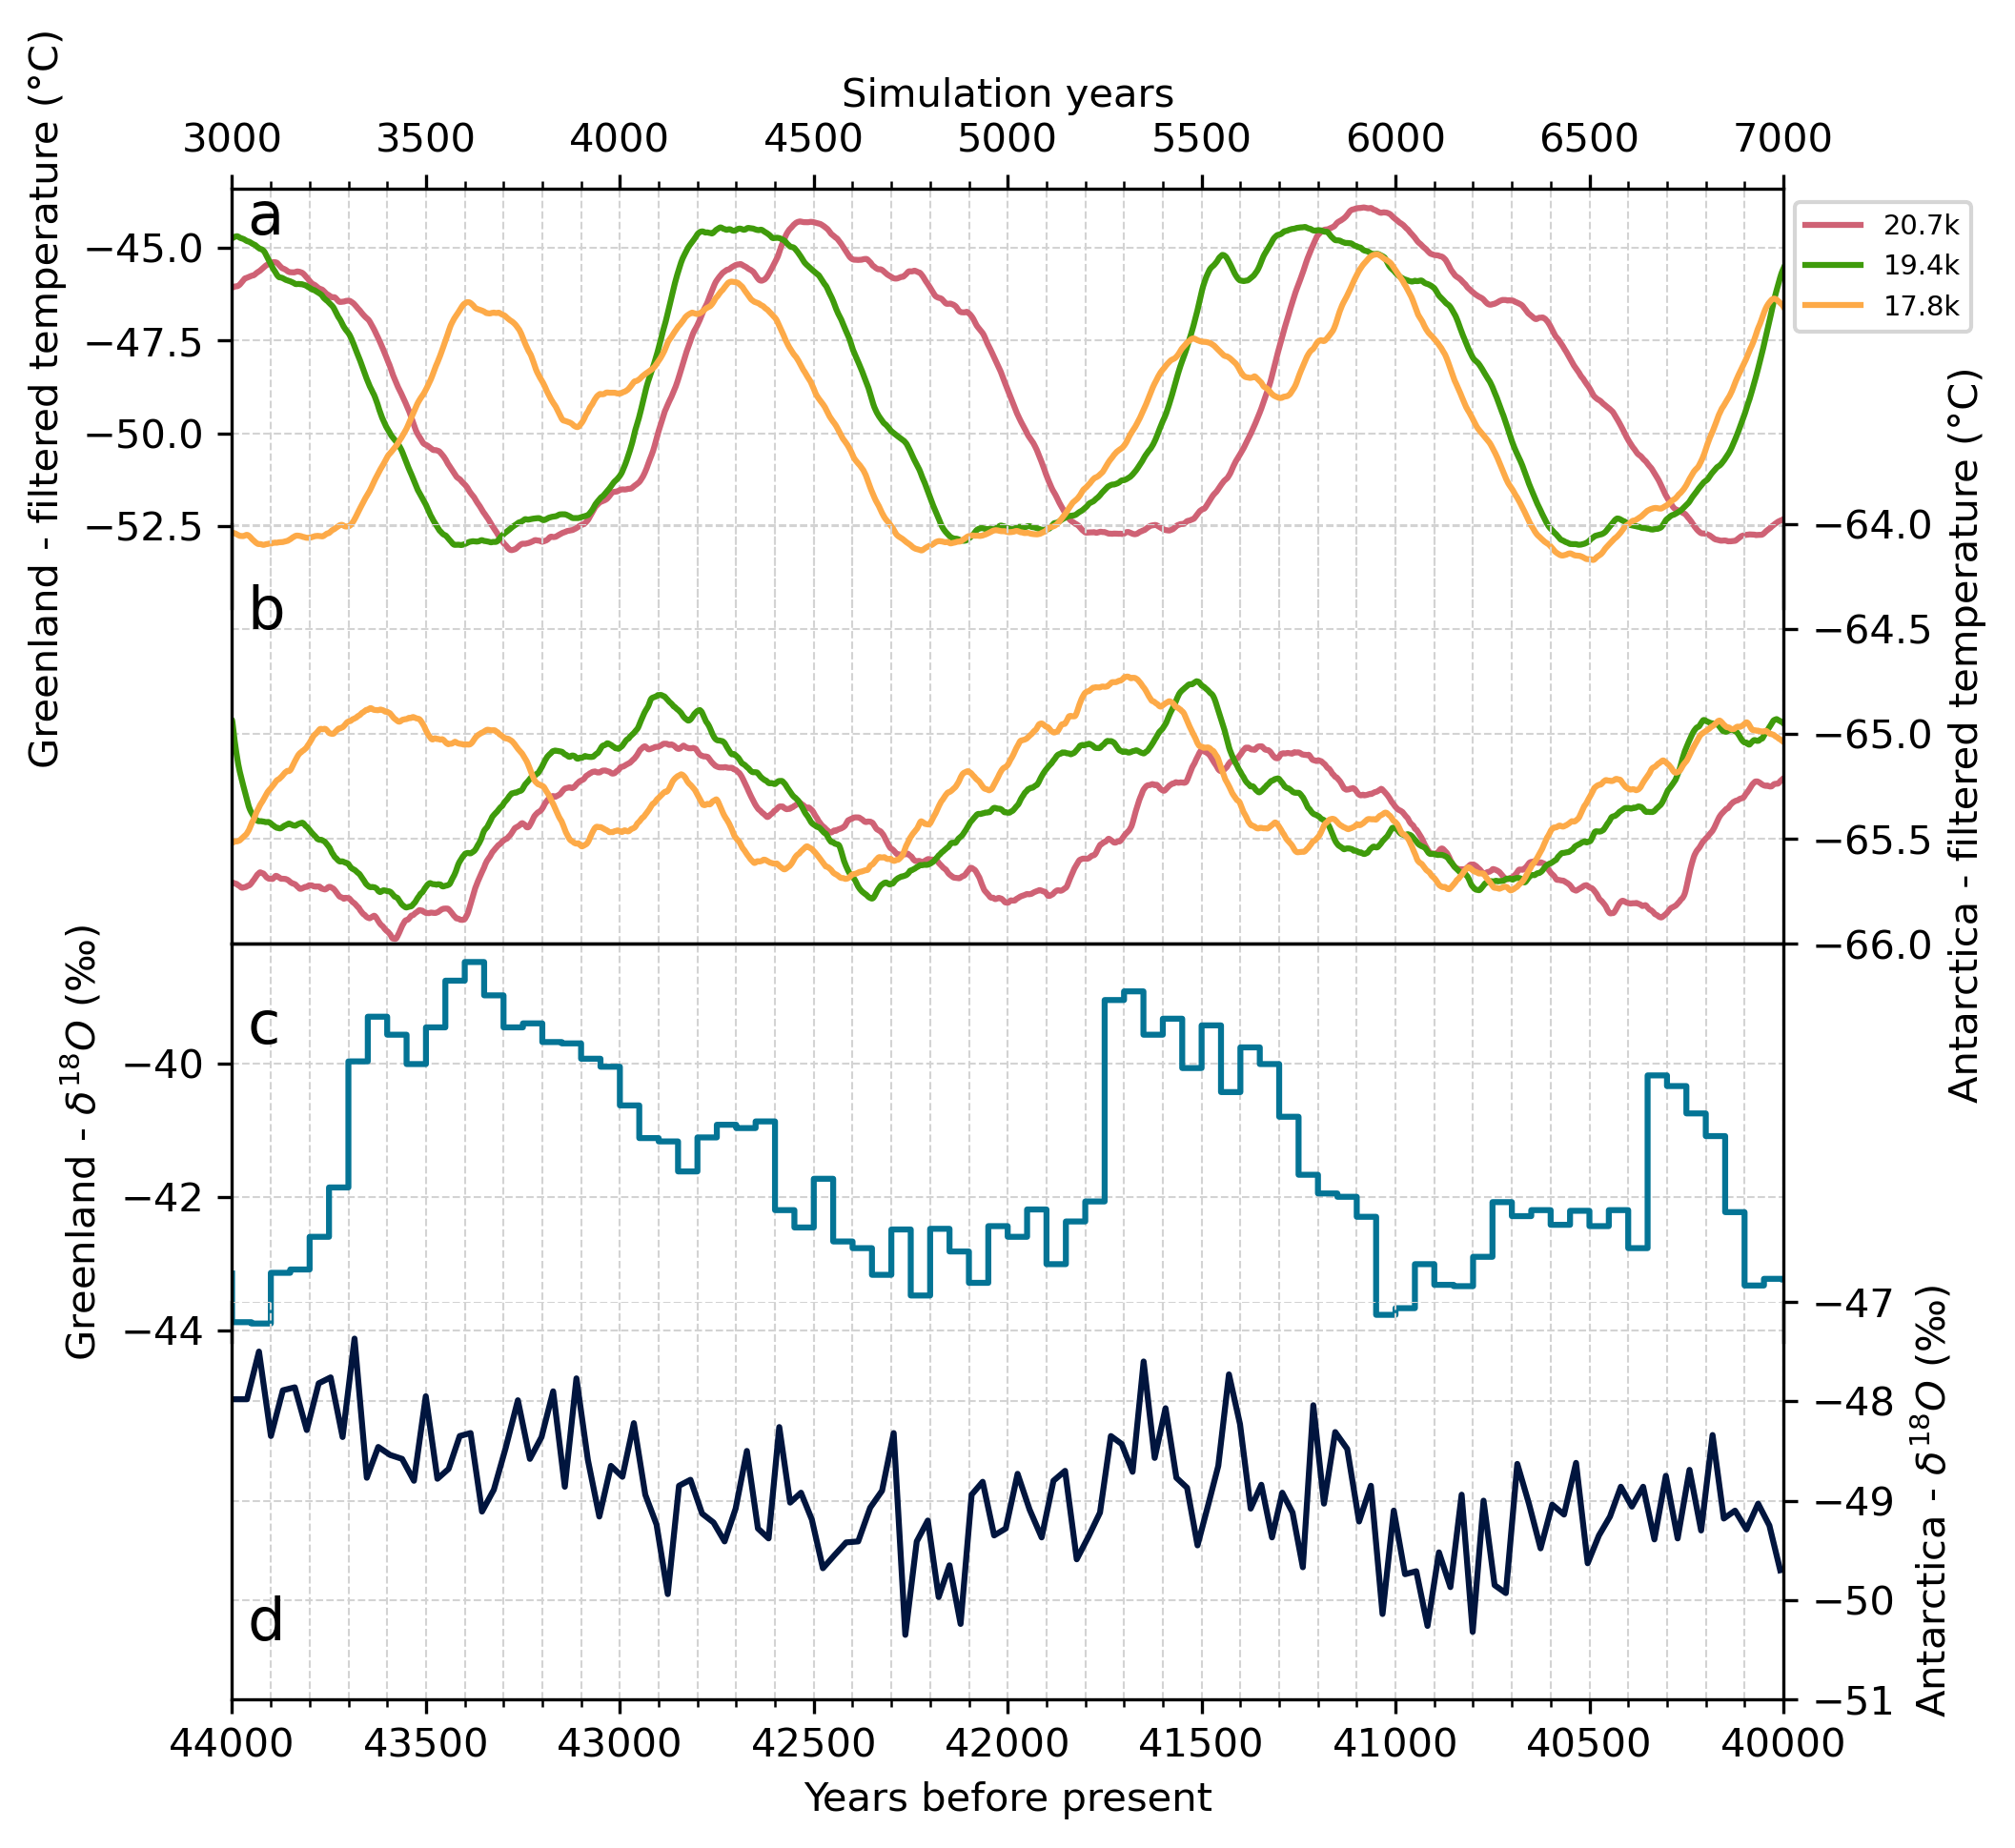

In [79]:
figMap = plt.figure(figsize=(7, 7), dpi=300)

grid = figMap.add_gridspec(nrows=2, ncols=1, hspace=0)
gridModel = grid[0].subgridspec(2, 1, hspace=-0.2)
axNGRIP= figMap.add_subplot(gridModel[0],facecolor='None')
axEPICA= figMap.add_subplot(gridModel[1],facecolor='None', sharex=axNGRIP)

gridData = grid[1].subgridspec(2, 1, hspace=-0.1)
axNGRIPD= figMap.add_subplot(gridData[0],facecolor='None')
axEPICAD= figMap.add_subplot(gridData[1],facecolor='None', sharex=axNGRIPD)

for expt in ['tfgbi', 'tfgbr', 'tfgbj']:
    axNGRIP.plot(ngrip[expt].processed_time(start_dates[expt]), ngripf[expt], color=colors[expt], linestyle="-", label=labels[expt])
    axEPICA.plot(epica[expt].processed_time(start_dates[expt]), epicaf[expt], color=colors[expt], linestyle="-")

axNGRIP.spines['bottom'].set_visible(False)
axNGRIP.set_ylabel('Greenland - filtered temperature (°C)')
axNGRIP.set_xlim(3000, 7000)
axNGRIP.xaxis.set_ticks_position('top')
axNGRIP.set_xlabel("Simulation years")
axNGRIP.xaxis.set_label_position('top')
axNGRIP.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIP.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIP.legend(fontsize='x-small', loc='upper right', bbox_to_anchor=(1.13, 1))
axNGRIP.annotate('a', xy=(0.01,0.89), xycoords='axes fraction', size=15)

axEPICA.spines['top'].set_visible(False)
axEPICA.tick_params(axis='x', colors='None', which='both')
axEPICA.xaxis.set_minor_locator(AutoMinorLocator())
axEPICA.set_ylim(-66, -64)
axEPICA.yaxis.set_ticks_position('right')
axEPICA.yaxis.set_label_position('right')
axEPICA.set_ylabel("Antarctica - filtered temperature (°C)")
axEPICA.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axEPICA.annotate('b', xy=(0.01,0.75), xycoords='axes fraction', size=15)

axNGRIPD.plot(proxy_ngrip.age/1000, proxy_ngrip.O18, color='xkcd:sea blue')
axEPICAD.plot(proxy_edml.age*1000, proxy_edml.O18, color='xkcd:navy')

axNGRIPD.spines['bottom'].set_visible(False)
axNGRIPD.set_ylabel('Greenland - $\delta^{18}O$ (‰)')
axNGRIPD.set_xlim(44000, 40000)
axNGRIPD.xaxis.set_ticks_position('top')
axNGRIPD.tick_params(axis='x', colors='None', which='both')
axNGRIPD.xaxis.set_label_position('top')
axNGRIPD.xaxis.set_minor_locator(AutoMinorLocator())
axNGRIPD.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axNGRIPD.annotate('c', xy=(0.01,0.75), xycoords='axes fraction', size=15)

axEPICAD.spines['top'].set_visible(False)
axEPICAD.xaxis.set_minor_locator(AutoMinorLocator())
axEPICAD.set_ylim(-51, -47)
axEPICAD.set_xlabel("Years before present")
axEPICAD.yaxis.set_ticks_position('right')
axEPICAD.yaxis.set_label_position('right')
axEPICAD.set_ylabel(r"Antarctica - $\delta^{18}O$ (‰)")
axEPICAD.grid(which = 'both', color='lightgrey', linestyle='--', linewidth=0.5)
axEPICAD.annotate('d', xy=(0.01,0.15), xycoords='axes fraction', size=15)